In [1]:
import category_encoders as ce
from collections import Counter
from geopy import distance
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import feature_selection
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from textblob import TextBlob
import time
import math


# Configuration parameters

In [2]:
KAGGLE_ENV = False
DEBUG = True
RANDOM_STATE = 18
TARGET_COLUMN_NAME = 'reviewer_score'
TEST_SIZE = 0.20

# cleanup
POST_CLEANUP_MASKS = None

# feature creation
BINARY_ENCODERS = None
ONEHOT_ENCODERS = None
TOP_TAGS_MAX_NUMBER = None
TOP_TAGS_LIST = None

# feature selection
CATEGORICAL_COLUMNS = None
CATEGORICAL_COLUMNS_MAX_NUM = None
NUMERIC_COLUMNS = None
NUMERIC_COLUMNS_MAX_NUM = None
TAGS_COUNTER = None

# feature transformation
COLUMNS_TO_STANDARDIZE = None
COLUMNS_TO_NORMALIZE = None
NORM_SCALER = None
STND_SCALER = None

# training
MAPE = None
CHUNK_TO_TRAIN = None
EXCLUDE_COLUMNS = None
N_ESTIMATORS = None
MODEL = None


# Utility

## Common functions

In [3]:
def debug_print(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)

def describe_hist_box(data, column, log=False):
    """Receives a dataframe and a column name.
    Prints out this column statistics and renders its historgam and a box diagram.
    If `log` is True then will apply logarithmic scale to the diagrams.

    Args:
        data (pd.DataFrame): The dataframe.
        column (str): Name of the column to analyze.
        log (bool, optional): A flag to apply the logarithmi scale to diagrams. Defaults to False.
    """

    data=data[[column]]

    print(data.describe())

    fig, ax = figax(rowcol=(2, 1), name=column)

    sns.histplot(ax=ax[0], data=data, binwidth=1)
    sns.boxplot(ax=ax[1], data=data, orient='h')

    if log:
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')

def figax(figsize=(7, 4), rowcol=None, axes=[0,0,1,1], name='Foo'):
    """Creates a matplot figure and returns it and its axes.

    Args:
        figsize (tuple, optional): Figure. Defaults to (7, 4).
        rowcol (tuple, optional): How many rows and cols in the figure. Defaults to None.
        axes (list, optional): Rect [left, bottom, width, height] of the new axes. Defaults to [0,0,1,1].
        name (str, optional): Figure name. Defaults to 'Foo'.

    Returns:
        _type_: _description_
    """
    fig = plt.figure(name, figsize=figsize)
    
    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax

def apply_binary(data, features, is_train_set):
    global BINARY_ENCODERS

    if is_train_set:
        BINARY_ENCODERS = dict()
    else:
        assert(type(BINARY_ENCODERS) == dict)

    all_columns = []

    for feature in features:
        # print(f'len(data[feature].unique()) = {len(data[feature].unique())}')
        if len(data[feature].unique()) > 2047:
            convert_rare_values_to_others(data, feature, how_many_to_keep=127)

        if BINARY_ENCODERS.get(feature) is None:
            BINARY_ENCODERS[feature] = ce.BinaryEncoder()
            BINARY_ENCODERS[feature].fit(data[feature])

        encoded_feature = BINARY_ENCODERS[feature].transform(data[feature])
        data.loc[:, encoded_feature.columns] = encoded_feature

        all_columns.extend(encoded_feature.columns)

    for col in all_columns:
        data[col] = np.int8(data[col])

    return all_columns

def apply_onehot(data, features, onehot_max, is_train_set):
    global ONEHOT_ENCODERS

    if is_train_set:
        ONEHOT_ENCODERS = dict()
    else:
        assert(type(ONEHOT_ENCODERS) == dict)

    all_columns = []

    for feature in features:
        if len(data[feature].unique()) > onehot_max:
            debug_print(f'"{feature}" unique values len id greater than onehot_max: {len(data[feature].unique())} > {onehot_max}')
            convert_rare_values_to_others(data, feature)
        
        if ONEHOT_ENCODERS.get(feature) is None:
            ONEHOT_ENCODERS[feature] = ce.OneHotEncoder()
            ONEHOT_ENCODERS[feature].fit(data[feature])

        encoded_feature = ONEHOT_ENCODERS[feature].transform(data[feature])

        data.loc[:, encoded_feature.columns] = encoded_feature

        all_columns.extend(encoded_feature.columns)

    for col in all_columns:
        data[col] = np.int8(data[col])

    return all_columns

def convert_rare_values_to_others(data, feature='', how_many_to_keep=15):
    value_counts = data[feature].value_counts()

    difference_times = value_counts[0] / value_counts[how_many_to_keep]

    if difference_times < 100:
        debug_print(f'!! convert_rare_values_to_others for "{feature}"')
        debug_print(f'value_counts: {len(value_counts)}')
        debug_print(f'value_counts[0]: {value_counts[0]}')
        debug_print(f'value_counts[{how_many_to_keep}]: {value_counts[how_many_to_keep]}')
        debug_print(f'difference is {difference_times} times')

    allowed_values = value_counts.index[0: how_many_to_keep]
    data[feature] = data[feature].apply(lambda x: x if x in allowed_values else '-- others --')

def logger(fn):
    """A decorator which will measure how long a function has been executing.

    Args:
        fn (function): Function to log.
    """
    def decorated(*args, **kwargs):
        debug_print(f'>>> fn. `{fn.__name__}` is running')
        ts = time.time()
        res = fn(*args, **kwargs)
        te = time.time()
        delta = round((te-ts) * 1000)
        sec_mls = 'mls'
        if delta > 1000:
            delta = round(delta / 1000, 1)
            sec_mls = 's'
        debug_print(f'<<< fn. `{fn.__name__}` finished, took {delta} {sec_mls}\n')
        return res
    return decorated


## Data loading functions

In [4]:
if KAGGLE_ENV:
    train_data_orig = pd.read_csv('../input/sf-booking/hotels_train.csv')
    test_data_orig = pd.read_csv('../input/sf-booking/hotels_test.csv')
    submission_data_orig = pd.read_csv('../input/sf-booking/submission.csv')
else:
    train_data_orig = pd.read_csv('./data/input/hotels_train.csv.zip')
    test_data_orig = pd.read_csv('./data/input/hotels_test.csv.zip')
    submission_data_orig = pd.read_csv('./data/input/submission.csv.zip')

def get_train_data(chunk=None):
    if chunk is None:
        return train_data_orig.copy()
    return train_data_orig[0:chunk].copy()

def get_test_data(chunk=None):
    if chunk is None:
        return test_data_orig.copy()
    return test_data_orig[0:chunk].copy()

def get_submission_data():
    return submission_data_orig.copy()


## Data cleanup functions

In [5]:
@logger
def cleanup_data(data, is_train_set):
    # we want to remove duplicates only for the train set
    if is_train_set:
        cleanup_data__remove_duplicates(data)

    # we want to remove anomalies only for the train set
    if is_train_set:
        cleanup_data__remove_anomalies(data)

    cleanup_data__add_missing_coords(data)

    cleanup_data__remove_useless_features(data)

    if data.isna().sum().sum() > 0:
        raise ValueError('Data set still has `nan` after cleaning.')

@logger
def cleanup_data__remove_duplicates(data):
    m = data.duplicated()
    
    if m.sum() == 0:
        return

    data.drop_duplicates(inplace=True)
    debug_print(f'removed {str(m.sum())} duplicated rows')

@logger
def cleanup_data__remove_anomalies(data):
    # in this project we wont handle anomalies during cleanup
    pass

@logger
def cleanup_data__add_missing_coords(data):
    """Receives data frame, looks for rows with missing `lat` and `lng`
    and fills them with help of `address_lat_lng.csv`.
    Function modifies the incoming data frame and returns nothing.

    Args:
        data (pd.DataFrame): input data set (train or test)
    """
    m1 = data['lat'].isna()
    m2 = data['lng'].isna()
    m = m1 | m2

    if m.sum() == 0:
        debug_print('There is no missing lat/lng')
        return

    # Lets try to populate missing lat/lng
    # we have stored some of them in addr_lat_lng.csv
    global KAGGLE_ENV
    if KAGGLE_ENV:
        addr_lat_lng_df = pd.read_csv('../input/hotel-lat-lng-by-address/address_lat_lng.csv')
    else:
        addr_lat_lng_df = pd.read_csv('./data/src/address_lat_lng.csv')

    def get_lat_lng(row):
        m = addr_lat_lng_df['hotel_address'] == row['hotel_address']
        if m.sum() == 1:
            lat, lng = addr_lat_lng_df[m][['lat', 'lng']].values[0]
            row['lat'] = lat
            row['lng'] = lng
        return row

    debug_print('Entries with missing lat/lng before: ' + str(data['lat'].isna().sum()))

    data.loc[m, ['lat', 'lng']] = data.apply(get_lat_lng, axis=1)

    debug_print('Entries with missing lat/lng after: ' + str(data['lat'].isna().sum()))

@logger
def cleanup_data__remove_useless_features(data):
    # in this project we wont remove features
    # but we will ignore usless features later
    # when we select most important ones
    pass


## Feature creation functions

In [6]:
@logger
def create_features(data, is_train_set):
    global TAGS_COUNTER
    global NUMERIC_COLUMNS
    global CATEGORICAL_COLUMNS

    if is_train_set:
        # We will use a Counter for tags to figure out
        # what the most popular tags are.
        TAGS_COUNTER = Counter()

        # We will create NUMERIC_COLUMNS and CATEGORICAL_COLUMNS
        # if the set is a train set
        NUMERIC_COLUMNS = list(get_train_data().select_dtypes(include=[np.number]).columns)
        CATEGORICAL_COLUMNS = []
    else:
        # Tags counter is created in a train set and the reused in a test set.
        # If it is a test set and the counter is not yet defined then it is an error.
        assert(type(TAGS_COUNTER) == Counter)
        # Same for numeric/cateogorical columns
        assert(type(NUMERIC_COLUMNS) == list)
        assert(type(CATEGORICAL_COLUMNS) == list)

        

    create_features__add_city(data)
    create_features__add_city_population(data, is_train_set)
    create_features__add_city_center_lat_lng(data)
    create_features__add_distance_to_city_center(data, is_train_set)
    create_features__add_time_features(data, is_train_set)
    create_features__add_review_polarity(data, is_train_set)
    create_features__recount_review_words(data, is_train_set)
    create_features__parse_days_since_review(data, is_train_set)
    create_features__parse_tags(data, is_train_set)
    create_features__add_tag_columns(data, is_train_set)
    create_features__apply_onehot(data, is_train_set)
    create_features__apply_binary(data, is_train_set)

@logger
def create_features__add_city(data):
    def get_city(addr):
        city_country = addr.split(' ')[-2:]
        if ' '.join(city_country) == 'United Kingdom':
            return 'London'
        return city_country[0]

    data.loc[:, 'hotel_city'] = data['hotel_address'].apply(get_city)
    debug_print(data['hotel_city'].value_counts())

@logger
def create_features__add_city_population(data, is_train_set):
    def get_city_population(city_name):
        # We know that there are only 6 cities in the set.
        # For each city we will rerturn its population taken from Wikipedia in millions
        if city_name == 'London':
            return 9
        elif city_name == 'Paris':
            return 2.1
        elif city_name == 'Vienna':
            return 1.9
        elif city_name == 'Barcelona':
            return 1.6
        elif city_name == 'Milan':
            return 1.4
        elif city_name == 'Amsterdam':
            return 0.9

    data.loc[:, 'city_population'] = data['hotel_city'].apply(get_city_population)

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.append('city_population')

@logger 
def create_features__add_city_center_lat_lng(data):
    if KAGGLE_ENV:
        concap = pd.read_csv('../input/europe-cities-lat-lng/concap.csv')
    else:
        concap = pd.read_csv('./data/src/concap.csv')

    concap_dict = dict()

    def get_city_lat_lng(city_name):
        nonlocal concap_dict

        if concap_dict.get(city_name) is None:
            m = concap['CapitalName'] == city_name

            if m.sum() != 1:
                raise ValueError(f'Unable to find "{city_name}" in concap')

            city = concap[m]

            concap_dict[city_name] = {
                'lat': float(city['CapitalLatitude'].values[0]),
                'lng': float(city['CapitalLongitude'].values[0]),
            }

        return concap_dict[city_name]

    data.loc[:, 'city_center_lat'] = data['hotel_city'].apply(lambda x: get_city_lat_lng(x)['lat'])
    data.loc[:, 'city_center_lng'] = data['hotel_city'].apply(lambda x: get_city_lat_lng(x)['lng'])

@logger
def create_features__add_distance_to_city_center(data, is_train_set):
    def get_distance(cols):
        coord_1 = (cols['city_center_lat'], cols['city_center_lng'])
        coord_2 = (cols['lat'], cols['lng'])
        return round(distance.distance(coord_1, coord_2).km, 1)

    debug_print('setting `distance_to_city_center_km`')
    data.loc[:, 'distance_to_city_center_km'] = data.apply(get_distance, axis=1)
    data['distance_to_city_center_km'] = np.float16(data['distance_to_city_center_km'])

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.append('distance_to_city_center_km')

    debug_print('setting `is_center`')
    data.loc[:, 'is_center'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x < 1.5 else 0)
    data['is_center'] = np.int8(data['is_center'])

    debug_print('setting `is_walking_distance`')
    data.loc[:, 'is_walking_distance'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x >= 1.5 and x < 3.0 else 0)
    data['is_walking_distance'] = np.int8(data['is_walking_distance'])

    debug_print('setting `is_not_far`')
    data.loc[:, 'is_not_far'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x >= 3.0 and x < 6.0 else 0)
    data['is_not_far'] = np.int8(data['is_not_far'])

    debug_print('setting `is_far`')
    data.loc[:, 'is_far'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x >= 6.0 and x < 12.0 else 0)
    data['is_far'] = np.int8(data['is_far'])

    debug_print('setting `is_far_away`')
    data.loc[:, 'is_far_away'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x > 12.0 else 0)
    data['is_far_away'] = np.int8(data['is_far_away'])

    if is_train_set:
        global CATEGORICAL_COLUMNS
        CATEGORICAL_COLUMNS.extend([
            'is_center', 
            'is_walking_distance', 
            'is_not_far', 
            'is_far', 
            'is_far_away'])

@logger
def create_features__add_time_features(data, is_train_set):
    data.loc[:, 'review_date_dt'] = pd.to_datetime(data['review_date'])
    data.loc[:, 'month',] = data['review_date_dt'].apply(lambda x: str(x.month))
    data.loc[:, 'year',] = data['review_date_dt'].apply(lambda x: str(x.year))
    data.loc[:, 'is_new_year',] = data['review_date_dt'].apply(lambda x: x.month == 1 and x.day <= 5)
    data.loc[:, 'is_xmas',] = data['review_date_dt'].apply(lambda x: x.month == 12 and x.day >= 25)

    data['is_new_year'] = np.int8(data['is_new_year'])
    data['is_xmas'] = np.int8(data['is_xmas'])

    if is_train_set:
        global CATEGORICAL_COLUMNS
        CATEGORICAL_COLUMNS.extend([
            'is_new_year',
            'is_xmas'])

@logger
def create_features__add_review_polarity(data, is_train_set):
    get_polarity = lambda text: TextBlob(text).sentiment.polarity

    data.loc[:, 'negative_review_polarity'] = data['negative_review'].apply(get_polarity)
    data['negative_review_polarity'] = np.float16(data['negative_review_polarity'])

    data.loc[:, 'positive_review_polarity'] = data['positive_review'].apply(get_polarity)
    data['positive_review_polarity'] = np.float16(data['positive_review_polarity'])

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.extend(['negative_review_polarity', 'positive_review_polarity'])

@logger
def create_features__recount_review_words(data, is_train_set):
    count_words = lambda text: len([word for word in text.split(' ') if len(word) > 0])

    data.loc[:, 'review_total_negative_word_counts_alt'] = data['negative_review'].apply(count_words)
    data['review_total_negative_word_counts_alt'] = np.int16(data['review_total_negative_word_counts_alt'])

    data.loc[:, 'review_total_positive_word_counts_alt'] = data['positive_review'].apply(count_words)
    data['review_total_positive_word_counts_alt'] = np.int16(data['review_total_positive_word_counts_alt'])

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.extend(['review_total_negative_word_counts_alt', 'review_total_positive_word_counts_alt'])

@logger
def create_features__parse_days_since_review(data, is_train_set):
    data.loc[:, 'days_since_review_int'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
    data['days_since_review_int'] = np.int16(data['days_since_review_int'])

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.append('days_since_review_int')

@logger
def create_features__parse_tags(data, is_train_set):
    def analize_tags(tag_list_json_str):
        tag_list = json.loads(tag_list_json_str.replace('\'', '"'))
        tag_list = [tag.strip() for tag in tag_list]
        global TAGS_COUNTER
        TAGS_COUNTER.update(tag_list)
        tags_count = len(tag_list)

        return tags_count

    data.loc[:, 'tags_count'] = data['tags'].apply(analize_tags)
    data['tags_count'] = np.int16(data['tags_count'])

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.append('tags_count')

@logger
def create_features__add_tag_columns(data, is_train_set):
    global TOP_TAGS_MAX_NUMBER
    assert(type(TOP_TAGS_MAX_NUMBER) == int)

    global TOP_TAGS_LIST
    if is_train_set:
        TOP_TAGS_LIST = [t[0] for t in TAGS_COUNTER.most_common(TOP_TAGS_MAX_NUMBER)]
        # debug_print('top_100_tags')
        # debug_print(TOP_TAGS_LIST)

    tag_dict = {}

    def fn(top_tag):
        def fn2(tags):
            nonlocal tag_dict
            if tag_dict.get(tags) is None:
                tag_dict[tags] = [tag.strip() for tag in json.loads(tags.replace('\'', '"'))]
            return 1 if top_tag in tag_dict[tags] else 0
        return fn2

    tag_series = [pd.Series(data=data['tags'].apply(fn(top_tag)), name=top_tag) for top_tag in TOP_TAGS_LIST]

    result_columns = list(data.columns)
    result_columns.extend(TOP_TAGS_LIST)

    objs = [data]
    objs.extend(tag_series)

    data.loc[:, result_columns] = pd.concat(objs=objs, axis=1)

    if is_train_set:
        global CATEGORICAL_COLUMNS
        CATEGORICAL_COLUMNS.extend(TOP_TAGS_LIST)

def create_features__apply_onehot(data, is_train_set):
    created_columns = apply_onehot(data, ['hotel_city', 'month', 'year'], 15, is_train_set)

    if is_train_set:
        global CATEGORICAL_COLUMNS
        CATEGORICAL_COLUMNS.extend(created_columns)

def create_features__apply_binary(data, is_train_set):
    created_columns = apply_binary(data, ['hotel_address', 'reviewer_nationality'], is_train_set)

    if is_train_set:
        global CATEGORICAL_COLUMNS
        CATEGORICAL_COLUMNS.extend(created_columns)


## Feature selection functions

In [7]:
def get_selected_numeric_features(data):
    columns = get_numeric_columns_by_importance(data)

    global EXCLUDE_COLUMNS
    if type(EXCLUDE_COLUMNS) == list:
        columns = [x for x in columns if x not in EXCLUDE_COLUMNS]

    if type(NUMERIC_COLUMNS_MAX_NUM) == int:
        return columns[0:NUMERIC_COLUMNS_MAX_NUM]
    
    return columns

def get_selected_categorical_features(data):
    columns = get_categorical_columns_by_importance(data)

    global EXCLUDE_COLUMNS
    if type(EXCLUDE_COLUMNS) == list:
        columns = [x for x in columns if x not in EXCLUDE_COLUMNS]

    if type(CATEGORICAL_COLUMNS_MAX_NUM) == int:
        return columns[0:CATEGORICAL_COLUMNS_MAX_NUM]
    
    return columns

def get_selected_features(data):
    selected_features = []

    global NUMERIC_COLUMNS
    if type(NUMERIC_COLUMNS) == list:
        selected_features.extend(get_selected_numeric_features(data))
    
    global CATEGORICAL_COLUMNS
    if type(CATEGORICAL_COLUMNS) == list:
        selected_features.extend(get_selected_categorical_features(data))

    return selected_features

def visualize_correlation(data, annot=True, high_corr_onlly=False):
    corr_data = data[get_selected_features(data)].corr()

    if high_corr_onlly == True:
        to_drop = []
        for col in corr_data.columns:
            corr_data.loc[col, col] = 0
            min = corr_data[col].min()
            max = corr_data[col].max()
            if min > -0.7 and max < 0.7:
                to_drop.append(col)

        corr_data = data[get_selected_features(data)].drop(columns=to_drop).corr()

    if len(corr_data.columns) == 0:
        print('There are no columns with high correlation.')
        return
    
    size = round(math.log(1 + len(corr_data.columns)) * 4)
    fig, ax = figax(figsize=(size, size), name='corr')
    sns.heatmap(ax=ax, data=corr_data, annot=annot)
    ax.set_title('Features correlation')
    plt.show()

def visualize_numeric_columns_importance(data, skip_diagram=False):
    global NUMERIC_COLUMNS
    assert(type(NUMERIC_COLUMNS) == list)

    global TARGET_COLUMN_NAME
    assert(TARGET_COLUMN_NAME in data.columns)

    X = data.drop(columns=[TARGET_COLUMN_NAME])
    y = data[TARGET_COLUMN_NAME]

    num_cols = [col for col in NUMERIC_COLUMNS if col in list(X.columns)]

    f_classif_results = feature_selection.f_classif(X[num_cols], y)

    data = pd.DataFrame(data=f_classif_results[0], index=num_cols, columns=['value'])
    data.sort_values(by=['value'], inplace=True, ascending=False)

    if skip_diagram == False:
        fig, ax = figax(figsize=(7, 4), name='corr')
        sns.barplot(ax=ax, data=data, x='value', y=data.index)
        ax.set_title('Importance of numeric features')

    return list(data.index)

def get_numeric_columns_by_importance(data):
    return visualize_numeric_columns_importance(data, skip_diagram=True)

def visualize_categorical_columns_importance(data, skip_diagram=False):
    global CATEGORICAL_COLUMNS
    assert(type(CATEGORICAL_COLUMNS) == list)

    global TARGET_COLUMN_NAME
    assert(TARGET_COLUMN_NAME in data.columns)

    X = data.drop(columns=[TARGET_COLUMN_NAME])
    y = data[TARGET_COLUMN_NAME]

    cat_cols = [col for col in CATEGORICAL_COLUMNS if col in list(X.columns)]

    chi2_results = feature_selection.chi2(X[cat_cols], y.astype('int'))

    data = pd.DataFrame(data=chi2_results[0], index=cat_cols, columns=['value'])
    data.sort_values(by=['value'], ascending=False, inplace=True)

    if skip_diagram == False:
        fig, ax = figax(figsize=(7, 25), name='corr')
        sns.barplot(ax=ax, data=data, x='value', y=data.index)
        ax.set_title('Importance of categorical features')

    return list(data.index)

def get_categorical_columns_by_importance(data):
    return visualize_categorical_columns_importance(data, skip_diagram=True)


## Transformation functions

In [8]:
@logger
def transform_features(data, is_train_set):
    transform_features__post_cleanup(data, is_train_set)
    transform_features__standardize_features(data, is_train_set)
    transform_features__normalize_features(data, is_train_set)

@logger
def transform_features__post_cleanup(data, is_train_set):
    global POST_CLEANUP_MASKS
    if POST_CLEANUP_MASKS is None:
        return

    if is_train_set:
        for m_lambda in POST_CLEANUP_MASKS:
            if m_lambda is not None:
                m = m_lambda(data)
                percent = round(m.sum() * 100.0 / data.shape[0], 1)
                data.drop(index=data[m].index, inplace=True)
                debug_print(f'Removed {m.sum()} rows ({percent}%)')

@logger
def transform_features__standardize_features(data, is_train_set):
    global COLUMNS_TO_STANDARDIZE
    assert(type(COLUMNS_TO_STANDARDIZE) == list)

    if len(COLUMNS_TO_STANDARDIZE) == 0:
        return

    global STND_SCALER
    if is_train_set:
        STND_SCALER = preprocessing.StandardScaler().fit(data[COLUMNS_TO_STANDARDIZE])

    ndarr = STND_SCALER.transform(data[COLUMNS_TO_STANDARDIZE])
    stnd_df = pd.DataFrame(ndarr, columns=[COLUMNS_TO_STANDARDIZE]).set_index(data.index)
    data.loc[:, COLUMNS_TO_STANDARDIZE] = stnd_df[COLUMNS_TO_STANDARDIZE]

@logger
def transform_features__normalize_features(data, is_train_set):
    global COLUMNS_TO_NORMALIZE
    assert(type(COLUMNS_TO_NORMALIZE) == list)

    if len(COLUMNS_TO_NORMALIZE) == 0:
        return

    global NORM_SCALER
    if is_train_set:
        NORM_SCALER = preprocessing.MinMaxScaler().fit(data[COLUMNS_TO_NORMALIZE])

    ndarr = NORM_SCALER.transform(data[COLUMNS_TO_NORMALIZE])
    norm_df = pd.DataFrame(ndarr, columns=[COLUMNS_TO_NORMALIZE]).set_index(data.index)
    data.loc[:, COLUMNS_TO_NORMALIZE] = norm_df[COLUMNS_TO_NORMALIZE]


## Training functions

In [9]:
@logger
def get_training_features(data):
    selected_features = get_selected_features(data)

    if len(selected_features) == 0:
        selected_features = list(data.select_dtypes(include=[np.number]).columns)

    global EXCLUDE_COLUMNS
    if type(EXCLUDE_COLUMNS) == list:
        for col in EXCLUDE_COLUMNS:
            if col in selected_features:
                selected_features.remove(col)

    global TARGET_COLUMN_NAME
    if TARGET_COLUMN_NAME in selected_features:
        selected_features.remove(TARGET_COLUMN_NAME)
    
    debug_print('Training features:')
    debug_print(selected_features)
    return selected_features

@logger
def split_to_train_test(data):
    X = data.copy()

    global TARGET_COLUMN_NAME
    y = data[TARGET_COLUMN_NAME]

    global TEST_SIZE
    global RANDOM_STATE
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    return X_train, X_test, y_train, y_test

@logger
def train_model(X_train, y_train):
    global N_ESTIMATORS
    assert(N_ESTIMATORS is not None)

    global RANDOM_STATE
    assert(RANDOM_STATE is not None)

    X_train = X_train[get_training_features(X_train)]

    global TARGET_COLUMN_NAME
    if TARGET_COLUMN_NAME in list(X_train.columns):
        X_train = X_train.drop(columns=[TARGET_COLUMN_NAME])

    global MODEL
    MODEL = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

    MODEL.fit(X_train, y_train)

@logger
def estimate_model(X_test, y_test):
    y_pred = predict(X_test)

    global MAPE
    MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)
    # print('MAPE:', round(MAPE, 4))

    return y_pred, MAPE

@logger
def train_and_estimate(data):
    X_train, X_test, y_train, y_test = split_to_train_test(data)

    training_columns = get_training_features(X_train)

    X_test = X_test[training_columns]

    train_model(X_train, y_train)

    return estimate_model(X_test, y_test)

@logger
def train_and_estimate_use_mask(data, m_lambda):
    global TEST_SIZE
    global RANDOM_STATE
    train_data, test_data = model_selection.train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    m = m_lambda(train_data)
    train_data.drop(index=train_data[m].index, inplace=True)

    global TARGET_COLUMN_NAME
    train_model(train_data, train_data[TARGET_COLUMN_NAME])

    selected_features = get_training_features(train_data)
    X_test = test_data[selected_features]
    y_test = test_data[TARGET_COLUMN_NAME]

    return estimate_model(X_test, y_test)

@logger
def predict(X_test):
    global MODEL
    y_pred = MODEL.predict(X_test)

    return y_pred

@logger
def train_and_make_submission(train_data, test_data, file_name):
    # TRAIN
    X_train = train_data.copy()
    
    if X_train.isna().sum().sum() > 0:
        X_train.fillna(0, inplace=True)

    global TARGET_COLUMN_NAME
    y_train = train_data[TARGET_COLUMN_NAME]

    train_model(X_train, y_train)

    # PREDICT
    X_test = test_data

    if X_test.isna().sum().sum() > 0:
        X_test.fillna(0, inplace=True)

    training_features = get_training_features(X_train)

    y_pred = predict(X_test[training_features])

    # SUBMISSION
    submission = get_submission_data()
    submission[TARGET_COLUMN_NAME] = y_pred

    if KAGGLE_ENV:
        submission.to_csv(file_name, index = False)
    else:
        submission.to_csv('./data/output/' + file_name, index = False)

@logger
def get_worst_predictions(train_data):
    """Receives train data, trains model, makes prepdiction
    on its part and returns that part with three additional columns:
    `y`, `y_pred` and `delta_pred` sorted by the latter.

    Args:
        train_data (pd.DataFrame): Train data cleaned and featured.
    """
    train_part, test_part = model_selection.train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # training model wihtout transforming features as we will analyze their initial values
    train_model(train_part, train_part[TARGET_COLUMN_NAME])

    # Making prediction on the test set with the model trained previously.
    # We need to use the test set because the model we have was not trained on this set.
    training_features = get_training_features(train_part)
    y_pred = predict(test_part[training_features])

    # Making the data_with_pred dataframe which will contain all the columns
    # of the train set and one more column `delta_pred` with difference
    # between y_pred and y.
    data_with_pred = test_part.copy()
    data_with_pred.loc[:, 'y'] = test_part[TARGET_COLUMN_NAME]
    data_with_pred.loc[:, 'y_pred'] = y_pred
    data_with_pred.loc[:, 'delta_pred'] = data_with_pred['y'] - data_with_pred['y_pred']

    return data_with_pred.sort_values(by='delta_pred', ascending=True)

# First submission (simple model)

Lets train on the numeric data we have and make a prediction on it.

In [10]:
DEBUG = True
N_ESTIMATORS = 10
NUMERIC_COLUMNS = None
CATEGORICAL_COLUMNS = None

train_data = get_train_data()
test_data = get_test_data()
train_and_make_submission(train_data, test_data, 'hotels_prediction_1.csv')

>>> fn. `train_and_make_submission` is running
>>> fn. `train_model` is running
>>> fn. `get_training_features` is running
Training features:
['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng']
<<< fn. `get_training_features` finished, took 0 mls

<<< fn. `train_model` finished, took 13.2 s

>>> fn. `get_training_features` is running
Training features:
['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng']
<<< fn. `get_training_features` finished, took 0 mls

>>> fn. `predict` is running
<<< fn. `predict` finished, took 458 mls

<<< fn. `train_and_make_submission` finished, took 14.6 s



The result is **14.59514**. Now lets try to improve it.

# Creating a featured model

## Train dataset loading

Start by loading the train set. We will only do do the first training on a small part of the whole training set.

In [11]:
CHUNK_TO_TRAIN = 10_000
train_data = get_train_data(CHUNK_TO_TRAIN)

## Train dataset cleaning

First thing to do the train set is to run `cleanup_data`. During the cleanup we will not remove any useless feature. All the features will remain in the dataframe, however we will select only the important ones for the training later.

In [12]:
cleanup_data(train_data, is_train_set=True)

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
<<< fn. `cleanup_data__remove_duplicates` finished, took 15 mls

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 0 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 61
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 984 mls

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 1.0 s



## Creating features

We need to define some constants before running `create_features` function. They will be used in:
- `create_features__add_review_polarity`
- `create_features__add_tag_columns`

In [13]:
TOP_TAGS_MAX_NUMBER = 200

create_features(train_data, is_train_set=True)

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       5138
Barcelona    1184
Amsterdam    1133
Paris        1097
Vienna        778
Milan         670
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 8 mls

>>> fn. `create_features__add_city_population` is running
<<< fn. `create_features__add_city_population` finished, took 2 mls

>>> fn. `create_features__add_city_center_lat_lng` is running
<<< fn. `create_features__add_city_center_lat_lng` finished, took 9 mls

>>> fn. `create_features__add_distance_to_city_center` is running
setting `distance_to_city_center_km`
setting `is_center`
setting `is_walking_distance`
setting `is_not_far`
setting `is_far`
setting `is_far_away`
<<< fn. `create_features__add_distance_to_city_center` finished, took 1.4 s

>>> fn. `create_features__add_time_features` is running
<<< fn. `create_features__add_time_features` finished, took 126 mls

>>> fn. `create_features__add_review_polar

## Features selection

Time to check feature importance.

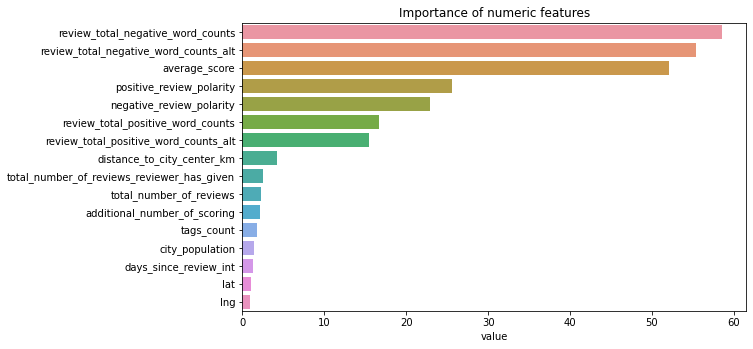

In [14]:
numeric_columns = visualize_numeric_columns_importance(train_data)

Now we can start to select features that will be used for training. Lets take 10 most important numeric columns.

In [15]:
NUMERIC_COLUMNS_MAX_NUM = 10

Also we will exclude columns `lat` and `lng` as they can't be useful to the model (at least from human point of view).

In [16]:
EXCLUDE_COLUMNS = ['lat', 'lng']

Doing the same for categorical columns.

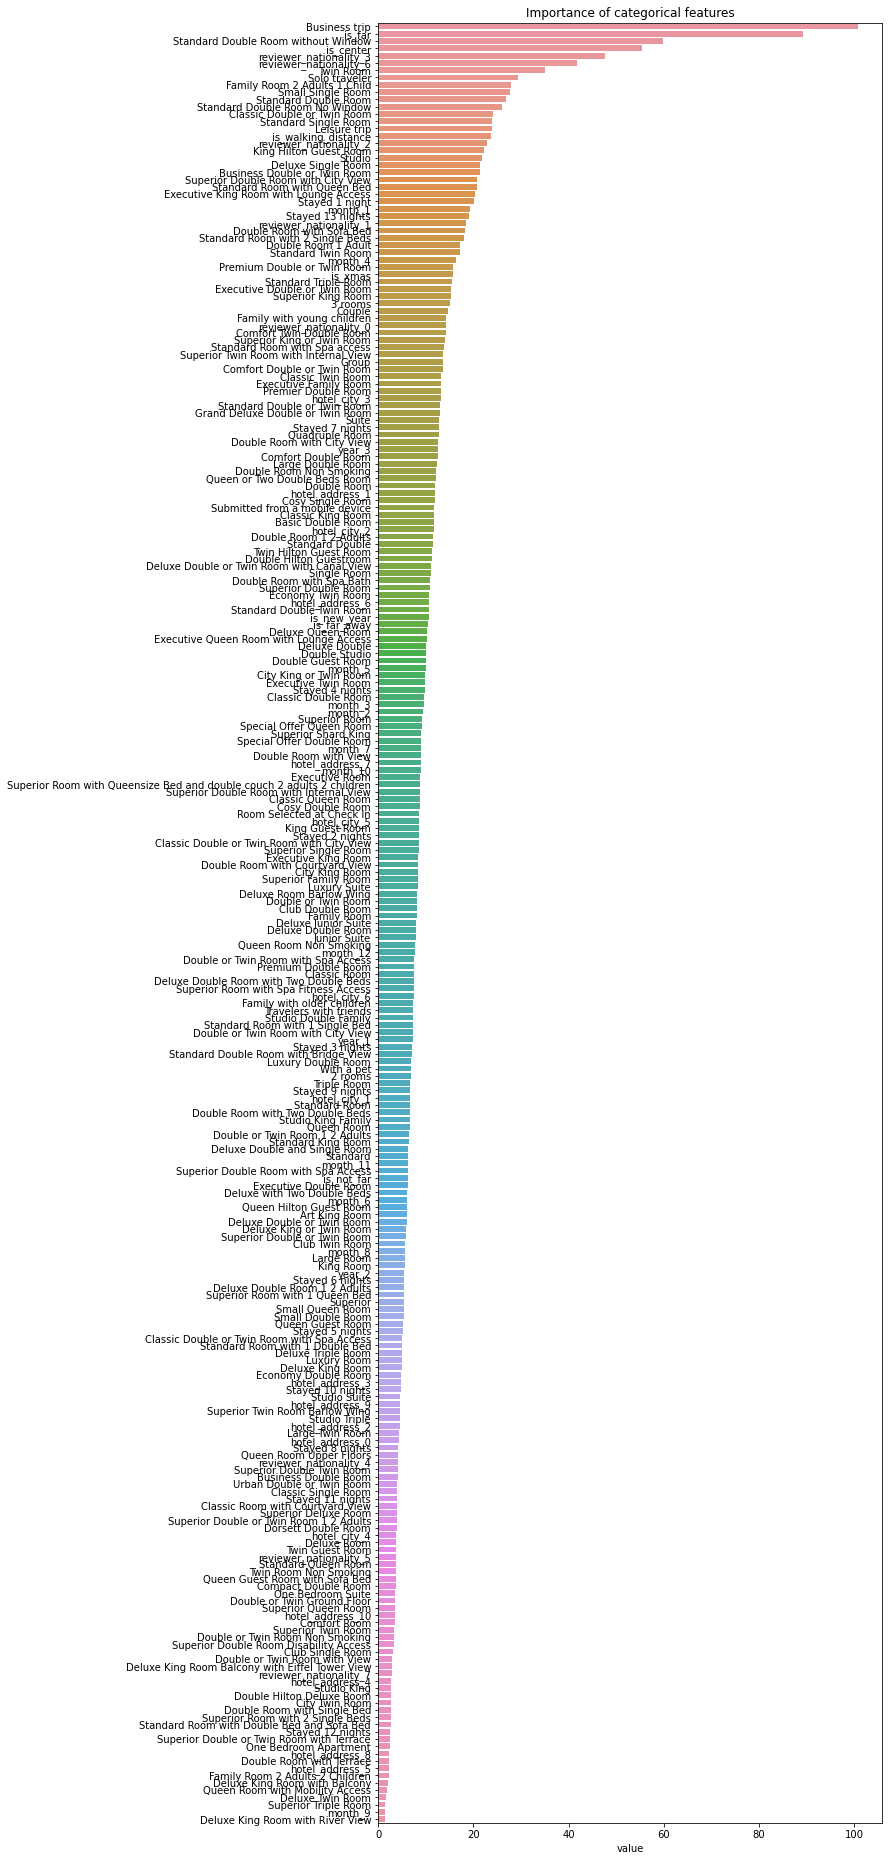

In [17]:
categorical_columns = visualize_categorical_columns_importance(train_data)

Let's continue selecting features for model training and add a small part of categorical columns.

In [18]:
CATEGORICAL_COLUMNS_MAX_NUM = 100

Lets render correlation heatmap to see if there is any multicollinearity. We will avoid cols with low correlations, otherwise the diagram will be unreadable.

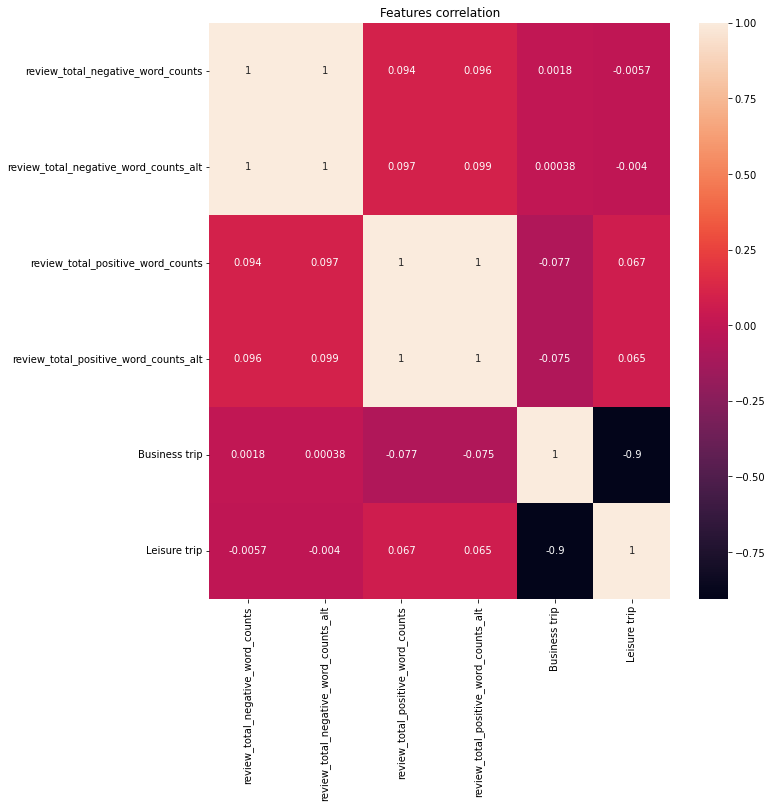

In [19]:
visualize_correlation(train_data, high_corr_onlly=True)

It shows us that there are four pairs of features with high correlations:
1. `review_total_negative_word_counts` with `review_total_negative_word_counts_alt`
2. `review_total_positive_word_counts` with `review_total_positive_word_counts_alt`
3. `total_number_of_reviews` with `additional_number_of_scoring`
4. `Business trip` with `Leisure trip`

Lets exclude `review_total_negative_word_counts`, `review_total_positive_word_counts`, `additional_number_of_scoring` and `Business trip`. All we need is to add them into `EXCLUDE_COLUMNS`


In [20]:
EXCLUDE_COLUMNS.extend([
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'additional_number_of_scoring',
    'Business trip',
])

## Data transformation

The last thing we need to do before training is feature transformation. Before doing that we will need to define `COLUMNS_TO_STANDARDIZE` and `COLUMNS_TO_NORMALIZE`. Lets visualize numeric columns distribution.

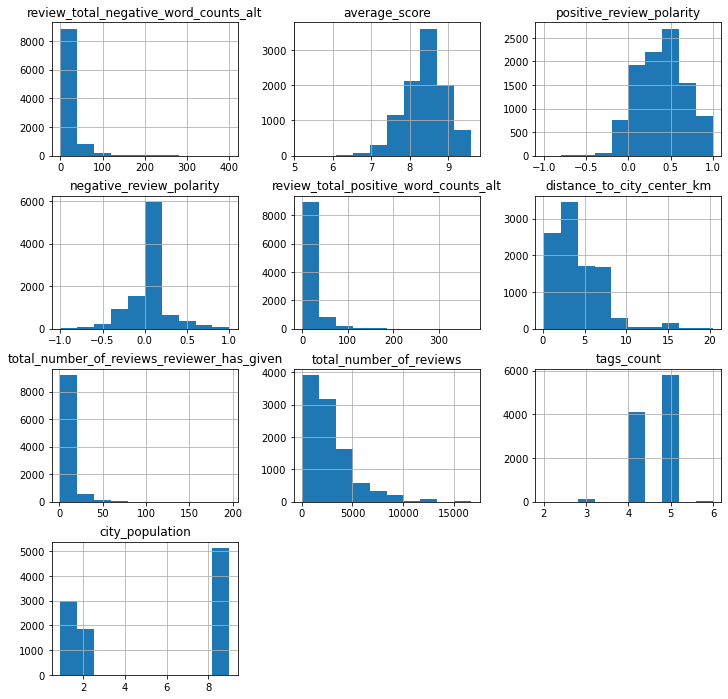

In [21]:
numeric_columns = get_selected_numeric_features(train_data)
train_data[numeric_columns].hist(figsize=(12, 12));

It seems `average_score`, `positive_review_polarity` and `negative_review_polarity` are normally distributed. Now we can split the columns into two groups and run `transform_features`

In [22]:
COLUMNS_TO_STANDARDIZE = [
    'average_score', 
    'positive_review_polarity',
    'negative_review_polarity',
]

selected_numeric_columns = get_selected_numeric_features(train_data)

COLUMNS_TO_NORMALIZE = [x for x in selected_numeric_columns if x not in COLUMNS_TO_STANDARDIZE]

transform_features(train_data, is_train_set=True)

>>> fn. `transform_features` is running
>>> fn. `transform_features__post_cleanup` is running
<<< fn. `transform_features__post_cleanup` finished, took 0 mls

>>> fn. `transform_features__standardize_features` is running
<<< fn. `transform_features__standardize_features` finished, took 7 mls

>>> fn. `transform_features__normalize_features` is running
<<< fn. `transform_features__normalize_features` finished, took 7 mls

<<< fn. `transform_features` finished, took 14 mls



## Training and estimating

In [23]:
DEBUG = False
y_pred, mape = train_and_estimate(train_data)
print(f'MAPE: {mape}')

MAPE: 0.1360655655663064


The model trained on a chunk of 30K rows shows an improvement. Lets train the model on whole data and submit second prediction.

# Second submission (featured model)

In [24]:
DEBUG = True
N_ESTIMATORS = 10
NUMERIC_COLUMNS_MAX_NUM = 10
CATEGORICAL_COLUMNS_MAX_NUM = 100

EXCLUDE_COLUMNS = [
    'lat',
    'lng',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'additional_number_of_scoring',
    'Business trip']

train_data = get_train_data()
cleanup_data(train_data, is_train_set=True)
create_features(train_data, is_train_set=True)
train_data_before_transform = train_data.copy()
transform_features(train_data, is_train_set=True)

test_data = get_test_data()
cleanup_data(test_data, is_train_set=False)
create_features(test_data, is_train_set=False)
test_data_before_transform = test_data.copy()
transform_features(test_data, is_train_set=False)

train_and_make_submission(train_data, test_data, 'hotels_prediction_2.csv')

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
removed 307 duplicated rows
<<< fn. `cleanup_data__remove_duplicates` finished, took 1.1 s

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 0 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 2448
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 37.7 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 39.1 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 244 mls

>>> fn. `create_features__add_city_p

The result is **13.04826**.

Lets try to improve the result with some additional techniques.

# Improving the model: Excluding extremes

Let's try to exclude extreme values out from the train set. For that we need to create featured model and then investigate the extreme values in numeric columns.

## Making featured dataset

## Function to test extremes

We need a function which receives the dataset with a list of masks and then does the following:
- splits the dataset into train and test sets
- uses a mask to remove extreme values from the test part
- trains a model
- estimates the model
- repeats for all the masks in the list

In [25]:
def test_extremes(data, masks_to_try):
    global DEBUG
    DEBUG = False

    global N_ESTIMATORS
    N_ESTIMATORS = 10

    for i, m_lambda in enumerate(masks_to_try):
        y_pred, mape = train_and_estimate_use_mask(data, m_lambda)
        print(f'MAPE for mask {i} is {round(mape, 4)}')


## Base MAPE

To speed up the process we will use a small part of `train_data_before_transform` (we defined it previously) and avoid data trasformation. It will be fine for testing some hypothesis.

Lets now calculate the base MAPE which we will try to improve.

In [26]:
DEBUG = False
N_ESTIMATORS = 10

train_data_before_transform_part = train_data_before_transform[:100_000].copy()

y_pred, mape = train_and_estimate(train_data_before_transform_part)

print(f'Base MAPE that needs to be improved: {mape}')

Base MAPE that needs to be improved: 0.1348293755967961


## Features to analyze

In [27]:
numeric_features = get_selected_numeric_features(train_data_before_transform_part)
training_features = get_training_features(train_data_before_transform_part)

for col in numeric_features:
    if col in training_features:
        print(col)

review_total_negative_word_counts_alt
average_score
positive_review_polarity
negative_review_polarity
review_total_positive_word_counts_alt
distance_to_city_center_km
total_number_of_reviews
total_number_of_reviews_reviewer_has_given
tags_count
city_population


### Analyzing<br>`review_total_negative_word_counts_alt`

       review_total_negative_word_counts_alt
count                          100000.000000
mean                               17.807390
std                                29.065983
min                                 0.000000
25%                                 2.000000
50%                                 7.000000
75%                                22.000000
max                               406.000000


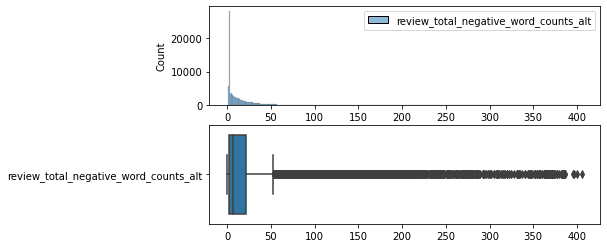

In [28]:
describe_hist_box(train_data_before_transform_part, 'review_total_negative_word_counts_alt')

In [29]:
masks_to_try = [
    lambda x: x['review_total_negative_word_counts_alt'] > 150,
    lambda x: x['review_total_negative_word_counts_alt'] > 250,
    lambda x: x['review_total_negative_word_counts_alt'] > 350,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.135
MAPE for mask 1 is 0.1349
MAPE for mask 2 is 0.1339


### Analyzing<br>`average_score`

       average_score
count  100000.000000
mean        8.398129
std         0.547636
min         5.200000
25%         8.100000
50%         8.400000
75%         8.800000
max         9.800000


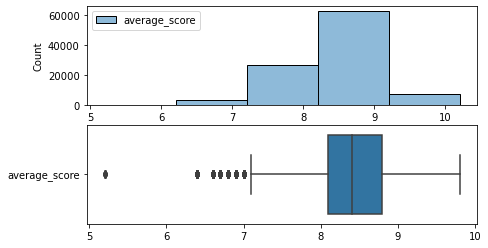

In [30]:
describe_hist_box(train_data_before_transform_part, 'average_score')

In [31]:
masks_to_try = [
    lambda x: x['average_score'] < 5.5,
    lambda x: x['average_score'] < 6,
    lambda x: x['average_score'] < 6.5,
    lambda x: x['average_score'] < 7,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1354
MAPE for mask 1 is 0.1354
MAPE for mask 2 is 0.1349
MAPE for mask 3 is 0.1349


### Analyzing<br>`positive_review_polarity`

       positive_review_polarity
count             100000.000000
mean                   0.373047
std                    0.297119
min                   -1.000000
25%                    0.139282
50%                    0.399902
75%                    0.583496
max                    1.000000


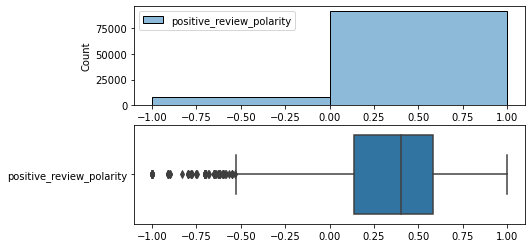

In [32]:
describe_hist_box(train_data_before_transform_part, 'positive_review_polarity')

In [33]:
masks_to_try = [
    lambda x: x['positive_review_polarity'] < -0.95,
    lambda x: x['positive_review_polarity'] < -0.85,
    lambda x: x['positive_review_polarity'] < -0.75,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1351
MAPE for mask 1 is 0.1353
MAPE for mask 2 is 0.1346


### Analyzing<br>`negative_review_polarity`

       negative_review_polarity
count             100000.000000
mean                   0.033173
std                    0.239624
min                   -1.000000
25%                   -0.050636
50%                    0.000000
75%                    0.150024
max                    1.000000


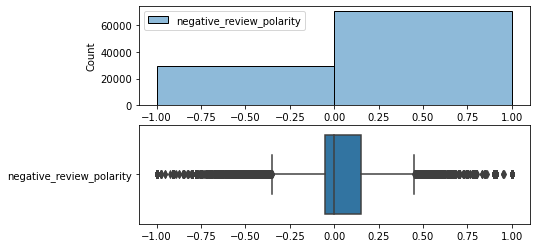

In [34]:
describe_hist_box(train_data_before_transform_part, 'negative_review_polarity')

In [35]:
masks_to_try = [
    lambda x: x['negative_review_polarity'] < -0.95,
    lambda x: x['negative_review_polarity'] < -0.85,
    lambda x: x['negative_review_polarity'] < -0.75,
    lambda x: x['negative_review_polarity'] > 0.75,
    lambda x: x['negative_review_polarity'] > 0.85,
    lambda x: x['negative_review_polarity'] > 0.95,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1352
MAPE for mask 1 is 0.1353
MAPE for mask 2 is 0.1346
MAPE for mask 3 is 0.1353
MAPE for mask 4 is 0.1348
MAPE for mask 5 is 0.1355


### Analyzing<br>`review_total_positive_word_counts_alt`

       review_total_positive_word_counts_alt
count                          100000.000000
mean                               16.459610
std                                21.326685
min                                 0.000000
25%                                 4.000000
50%                                10.000000
75%                                21.000000
max                               381.000000


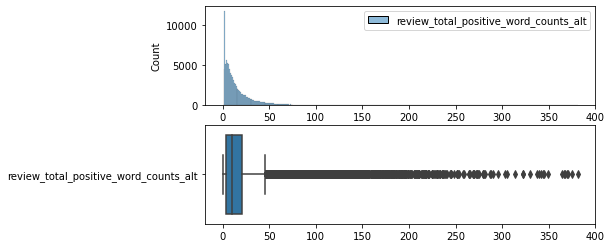

In [36]:
describe_hist_box(train_data_before_transform_part, 'review_total_positive_word_counts_alt')

In [37]:
masks_to_try = [
    lambda x: x['review_total_positive_word_counts_alt'] > 150,
    lambda x: x['review_total_positive_word_counts_alt'] > 250,
    lambda x: x['review_total_positive_word_counts_alt'] > 350,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1347
MAPE for mask 1 is 0.1355
MAPE for mask 2 is 0.1355


### Analyzing<br>`distance_to_city_center_km`

       distance_to_city_center_km
count               100000.000000
mean                          NaN
std                      0.000000
min                      0.099976
25%                      2.099609
50%                      3.400391
75%                      5.601562
max                     20.406250


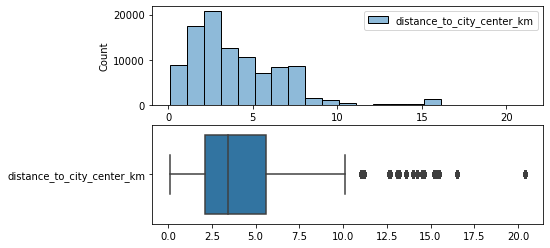

In [38]:
describe_hist_box(train_data_before_transform_part, 'distance_to_city_center_km')

In [39]:
masks_to_try = [
    lambda x: x['distance_to_city_center_km'] > 15,
    lambda x: x['distance_to_city_center_km'] > 17,
    lambda x: x['distance_to_city_center_km'] > 19,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1354
MAPE for mask 1 is 0.1351
MAPE for mask 2 is 0.1351


### Analyzing<br>`total_number_of_reviews`

       total_number_of_reviews
count            100000.000000
mean               2750.972460
std                2323.338199
min                  43.000000
25%                1158.000000
50%                2140.000000
75%                3633.000000
max               16670.000000


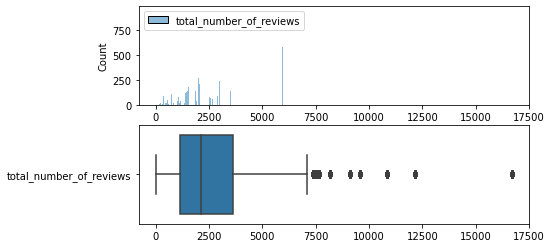

In [40]:
describe_hist_box(train_data_before_transform_part, 'total_number_of_reviews')

In [41]:
masks_to_try = [
    lambda x: x['total_number_of_reviews'] > 7500,
    lambda x: x['total_number_of_reviews'] > 10000,
    lambda x: x['total_number_of_reviews'] > 12500,
    lambda x: x['total_number_of_reviews'] > 15000,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1349
MAPE for mask 1 is 0.1354
MAPE for mask 2 is 0.1352
MAPE for mask 3 is 0.1352


### Analyzing<br>`total_number_of_reviews_reviewer_has_given`

       total_number_of_reviews_reviewer_has_given
count                               100000.000000
mean                                     7.189670
std                                     11.083063
min                                      1.000000
25%                                      1.000000
50%                                      3.000000
75%                                      8.000000
max                                    315.000000


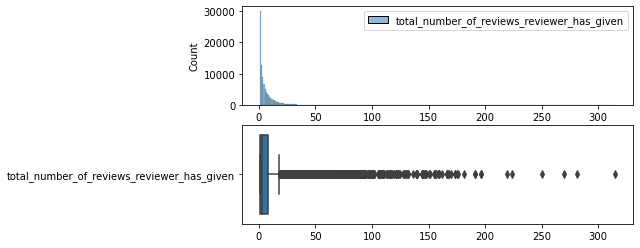

In [42]:
describe_hist_box(train_data_before_transform_part, 'total_number_of_reviews_reviewer_has_given')

In [43]:
masks_to_try = [
    lambda x: x['total_number_of_reviews_reviewer_has_given'] > 150,
    lambda x: x['total_number_of_reviews_reviewer_has_given'] > 200,
    lambda x: x['total_number_of_reviews_reviewer_has_given'] > 250,
    lambda x: x['total_number_of_reviews_reviewer_has_given'] > 300,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1346
MAPE for mask 1 is 0.1354
MAPE for mask 2 is 0.1349
MAPE for mask 3 is 0.1347


### Analyzing<br>`tags_count`

          tags_count
count  100000.000000
mean        4.569130
std         0.519292
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         6.000000


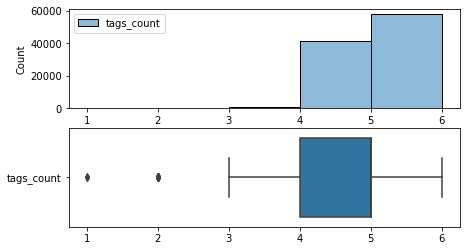

In [44]:
describe_hist_box(train_data_before_transform_part, 'tags_count')

In [45]:
masks_to_try = [
    lambda x: x['tags_count'] < 2,
    lambda x: x['tags_count'] < 3,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1352
MAPE for mask 1 is 0.1349


### Analyzing<br>`reviewer_score`

       reviewer_score
count   100000.000000
mean         8.403381
std          1.629618
min          2.500000
25%          7.500000
50%          8.800000
75%          9.600000
max         10.000000


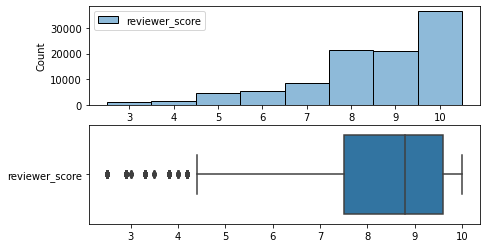

In [46]:
describe_hist_box(train_data_before_transform_part, TARGET_COLUMN_NAME)

In [47]:
masks_to_try = [
    lambda x: x[TARGET_COLUMN_NAME] == 2.5,
    lambda x: x[TARGET_COLUMN_NAME] < 3,
    lambda x: x[TARGET_COLUMN_NAME] < 3.5,
    lambda x: x[TARGET_COLUMN_NAME] < 4,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1354
MAPE for mask 1 is 0.1362
MAPE for mask 2 is 0.1364
MAPE for mask 3 is 0.139


### Analyzing<br>`review_total_negative_word_counts_alt`<br>one more time

We don't see a significant improvement of MAPE on any of tested continous numeric features. We may try to test the `review_total_negative_word_counts_alt` again but on the full train set this time.

In [48]:
train_data = train_data_before_transform.copy()

y_pred, mape = train_and_estimate(train_data)

print(f'Base MAPE that needs to be improved: {mape}')

Base MAPE that needs to be improved: 0.1326359165701411


In [49]:
masks_to_try = [
    lambda x: x['review_total_negative_word_counts_alt'] > 325,
    lambda x: x['review_total_negative_word_counts_alt'] > 350,
    lambda x: x['review_total_negative_word_counts_alt'] > 375,
    lambda x: x['review_total_negative_word_counts_alt'] > 400,
]

test_extremes(train_data_before_transform_part, masks_to_try)

MAPE for mask 0 is 0.1344
MAPE for mask 1 is 0.1339
MAPE for mask 2 is 0.1351
MAPE for mask 3 is 0.135


We failed to improve the model by excludig the extremve values—none of the action above improved the estimation.

# Improving the model: Most important features

## Selecting number of numeric features 

We will now train the model with different number of numeric columns to see which one gives the best MAPE.

In [50]:
CATEGORICAL_COLUMNS_MAX_NUM = 100
N_ESTIMATORS = 10
DEBUG = False

train_data_before_transform_part = train_data_before_transform[0:30_000]
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None

for num in range(5, len(NUMERIC_COLUMNS) + 1):
    NUMERIC_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data_before_transform_part)
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

MAPE 0.1347883411102335 for 5 numeric columns
MAPE 0.13480688118498924 for 6 numeric columns
MAPE 0.1341685598450785 for 7 numeric columns
MAPE 0.13385662674150156 for 8 numeric columns
MAPE 0.1349595170594087 for 9 numeric columns
MAPE 0.135274987853272 for 10 numeric columns
MAPE 0.13505752566014717 for 11 numeric columns
MAPE 0.13505752566014717 for 12 numeric columns
MAPE 0.13505752566014717 for 13 numeric columns
MAPE 0.13505752566014717 for 14 numeric columns
MAPE 0.13505752566014717 for 15 numeric columns
MAPE 0.13505752566014717 for 16 numeric columns
MAPE 0.13505752566014717 for 17 numeric columns
Best MAPE 0.13385662674150156 achieved with 8 numeric columns


Looks like our best optioin is 8 numeric columns. But we deliberately reduced the number of estimators to speed up the testing. Lets increase it a bit to check how it influences the results.

In [51]:
CATEGORICAL_COLUMNS_MAX_NUM = 100
N_ESTIMATORS = 50
DEBUG = False

train_data_before_transform_part = train_data_before_transform[0:30_000]
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None

for num in range(5, len(NUMERIC_COLUMNS) + 1):
    NUMERIC_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data_before_transform_part)
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

MAPE 0.13039579567839224 for 5 numeric columns
MAPE 0.13072832617345004 for 6 numeric columns
MAPE 0.13059911813094432 for 7 numeric columns
MAPE 0.13070748019345318 for 8 numeric columns
MAPE 0.13091471341489536 for 9 numeric columns
MAPE 0.13103441090040688 for 10 numeric columns
MAPE 0.13106831569755548 for 11 numeric columns
MAPE 0.13106831569755548 for 12 numeric columns
MAPE 0.13106831569755548 for 13 numeric columns
MAPE 0.13106831569755548 for 14 numeric columns
MAPE 0.13106831569755548 for 15 numeric columns
MAPE 0.13106831569755548 for 16 numeric columns
MAPE 0.13106831569755548 for 17 numeric columns
Best MAPE 0.13039579567839224 achieved with 5 numeric columns


This time our best choice is 5 numeric columns. It appears that the number of estimators does influence the comparative tests. Lets do one more test up to 10 numeric columns for a bigger data part.

In [52]:
CATEGORICAL_COLUMNS_MAX_NUM = 100
N_ESTIMATORS = 100
DEBUG = False

train_data_before_transform_part = train_data_before_transform[0:100_000]
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None

for num in range(3, 10):
    NUMERIC_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data_before_transform_part)
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

MAPE 0.1403353145597001 for 3 numeric columns
MAPE 0.1368042329326921 for 4 numeric columns
MAPE 0.12999820197398923 for 5 numeric columns
MAPE 0.13010334859218609 for 6 numeric columns
MAPE 0.13029153821133904 for 7 numeric columns
MAPE 0.13030185233037542 for 8 numeric columns
MAPE 0.1302734225521924 for 9 numeric columns
Best MAPE 0.12999820197398923 achieved with 5 numeric columns


Due to the results we will use 5 numeric columns.

In [53]:
NUMERIC_COLUMNS_MAX_NUM = 5

Lets now test the categorical columns. We will draw a graph to simplify interpretation.

Best MAPE 0.13367589596790955 achieved with 118 numeric columns


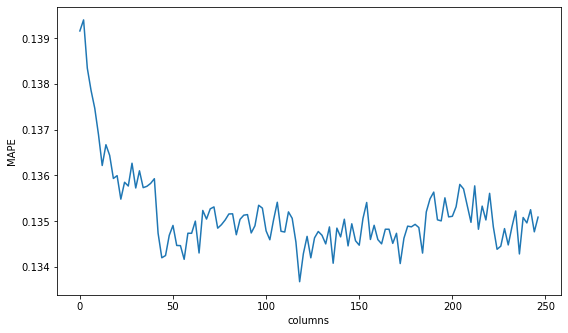

In [54]:
NUMERIC_COLUMNS_MAX_NUM = 5
N_ESTIMATORS = 10
DEBUG = False

train_data_before_transform_part = train_data_before_transform[0:30_000]
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None
data = []

for num in range(0, len(CATEGORICAL_COLUMNS) + 1, 2):
    CATEGORICAL_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data_before_transform_part)
    data.append([num, mape])
    # print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

df = pd.DataFrame(columns=['columns', 'MAPE'], data=data)

fig, ax = figax()

sns.lineplot(x='columns', y='MAPE', data=df);

Lets run one more test on a bigger part of data.

Best MAPE 0.13145556323072558 achieved with 133 numeric columns


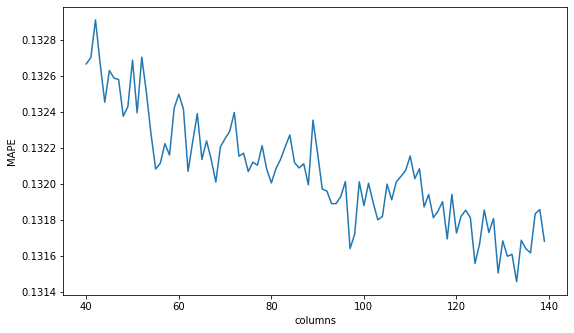

In [55]:
NUMERIC_COLUMNS_MAX_NUM = 5
N_ESTIMATORS = 20
DEBUG = False

train_data_before_transform_part = train_data_before_transform[0:100_000]
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None
data = []

for num in range(40, 140):
    CATEGORICAL_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data_before_transform_part)
    data.append([num, mape])
    # print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

df = pd.DataFrame(columns=['columns', 'MAPE'], data=data)

fig, ax = figax()

sns.lineplot(x='columns', y='MAPE', data=df);

According to the results our best choice is 133 categorical columns.

In [56]:
CATEGORICAL_COLUMNS_MAX_NUM = 133

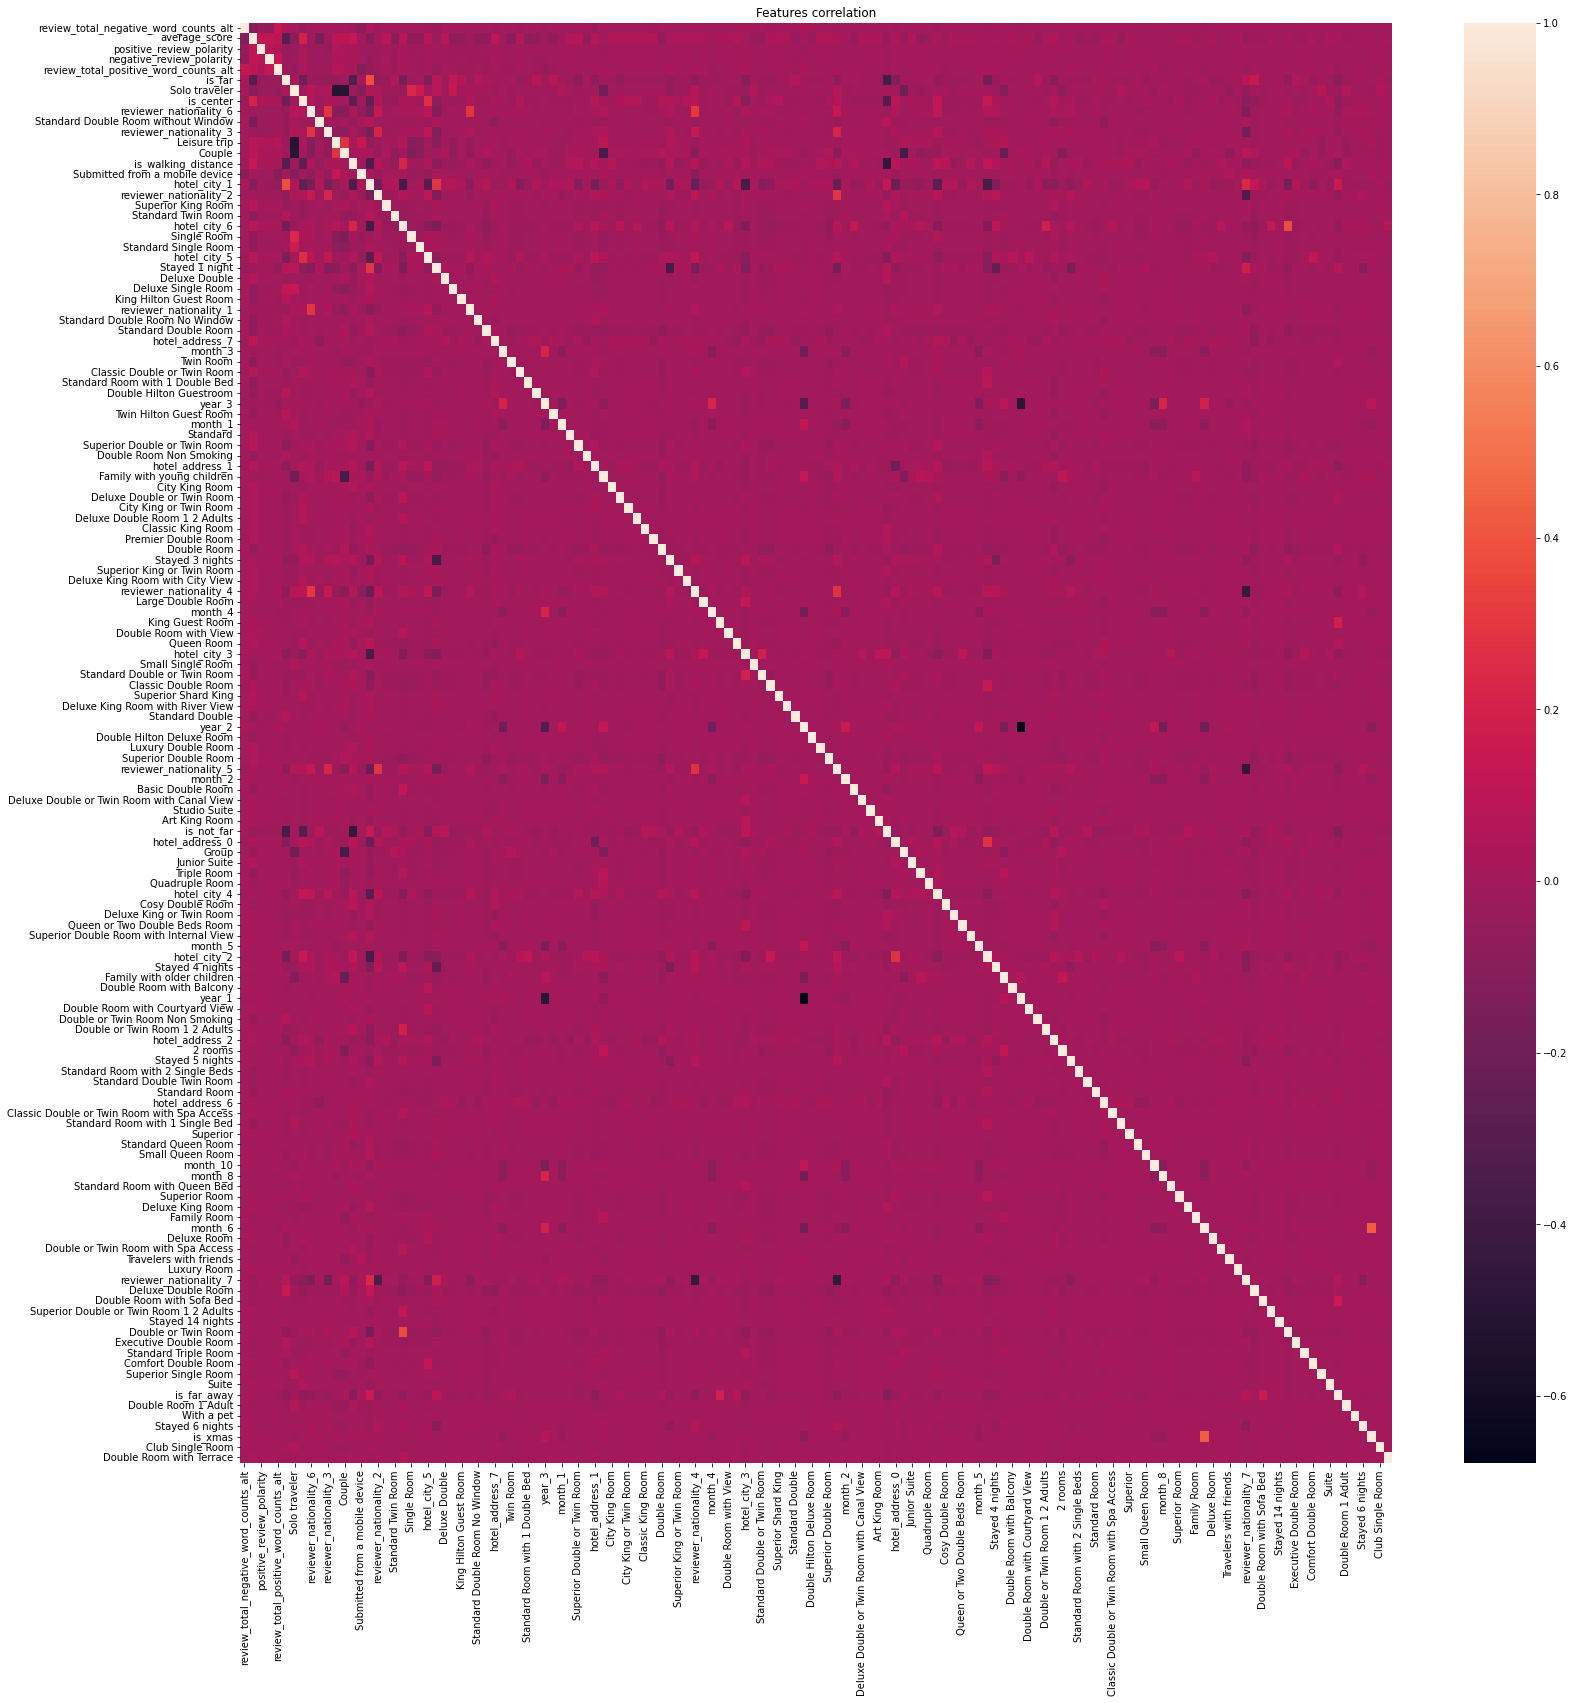

In [57]:
visualize_correlation(train_data_before_transform, annot=False)

Lets test again for multicolinearity. As the number of features is too big we will only keep columns with high correlation.

In [58]:
visualize_correlation(train_data_before_transform, high_corr_onlly=True)

There are no columns with high correlation.


# Third submission (most important features)

In [60]:
DEBUG = True
N_ESTIMATORS = 100
NUMERIC_COLUMNS_MAX_NUM = 5
CATEGORICAL_COLUMNS_MAX_NUM = 103
EXCLUDE_COLUMNS = [
    'lat',
    'lng',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'additional_number_of_scoring',
    'Business trip']

train_data = get_train_data()
cleanup_data(train_data, is_train_set=True)
create_features(train_data, is_train_set=True)
train_data_before_transform = train_data.copy()
transform_features(train_data, is_train_set=True)

test_data = get_test_data()
cleanup_data(test_data, is_train_set=False)
create_features(test_data, is_train_set=False)
test_data_before_transform = test_data.copy()
transform_features(test_data, is_train_set=False)

train_and_make_submission(train_data, test_data, 'hotels_prediction_3.csv')

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
removed 307 duplicated rows
<<< fn. `cleanup_data__remove_duplicates` finished, took 1.1 s

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 0 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 2448
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 38.2 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 39.6 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 240 mls

>>> fn. `create_features__add_city_p

The result is **12.94009** which is a little bit better than the previous one.

To improve MAPE even more lets try to investigate the worst predictions.

# Further analysis

## Investigating worst predictions

Lets try to check in what data our model makes the worst predictions. For that we will make a prediction on a part of train data and then compare the predictions with real `reviewer_score` values.

In [61]:
DEBUG = False
N_ESTIMATORS = 25

train_data = train_data_before_transform[0:30_000]

data_with_pred = get_worst_predictions(train_data)

Let's sort the data frame by `delta_pred` and analyze the rows with
the biggest difference.

In [62]:
data_with_pred.sort_values(by='delta_pred', ascending=True, inplace=True)

data_with_pred.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,y,y_pred,delta_pred
26954,7 Pepys Street City of London London EC3N 4AF ...,1936,6/22/2017,8.7,DoubleTree by Hilton Hotel London Tower of London,United Kingdom,No Negative,0,7491,Very close to the underground The area on the...,...,0,0,0,0,0,0,1,2.5,9.676,-7.176
21882,Westminster Bridge Road Lambeth London SE1 7UT...,2623,6/13/2016,8.7,Park Plaza Westminster Bridge London,Australia,The weather,4,12158,Location,...,0,1,0,0,1,0,0,2.9,9.428,-6.528
6314,Spuistraat 288 292 Amsterdam City Center 1012 ...,407,8/11/2016,8.2,NH City Centre Amsterdam,United Kingdom,The pet wasn t allowed,7,3417,The pet wasn t allowed,...,0,0,0,0,0,0,1,2.9,8.420,-5.520
3698,Aletta Jacobslaan 7 Slotervaart 1066 BP Amster...,555,10/19/2015,8.4,Corendon Vitality Hotel Amsterdam,Turkey,terrrible hotel don t stay in this hotel,9,4410,No Positive,...,0,1,0,1,0,1,1,2.5,7.820,-5.320
6312,Travessera de les Corts 150 152 Les Corts 0802...,111,6/2/2017,8.1,NH Barcelona Stadium,United Kingdom,the staff were rude the room service didn t c...,15,1257,the rooftop pool was beautiful,...,0,0,0,0,0,0,1,3.3,8.592,-5.292


It shows us to many features. Lets analyze only some of them.

In [63]:
features = [
    'y',
    'y_pred',
    'delta_pred',
    'average_score',
    'negative_review',
    'negative_review_polarity',
    'positive_review',
    'positive_review_polarity',
    'total_number_of_reviews',
    'distance_to_city_center_km',
    'review_date_dt',
]
data_with_pred[features][0:10]

,y,y_pred,delta_pred,average_score,negative_review,negative_review_polarity,positive_review,positive_review_polarity,total_number_of_reviews,distance_to_city_center_km,review_date_dt
26954,2.5,9.676,-7.176,8.7,No Negative,0.150024,Very close to the underground The area on the...,0.555176,7491,1.299805,2017-06-22
21882,2.9,9.428,-6.528,8.7,The weather,0.000000,Location,0.000000,12158,2.300781,2016-06-13
6314,2.9,8.420,-5.520,8.2,The pet wasn t allowed,0.000000,The pet wasn t allowed,0.000000,3417,2.900391,2016-08-11
3698,2.5,7.820,-5.320,8.4,terrrible hotel don t stay in this hotel,0.000000,No Positive,-0.113647,4410,5.800781,2015-10-19
6312,3.3,8.592,-5.292,8.1,the staff were rude the room service didn t c...,0.022217,the rooftop pool was beautiful,0.850098,1257,4.699219,2017-06-02
1785,2.5,7.760,-5.260,8.2,The service and the room,0.000000,The lobby,0.000000,901,5.500000,2017-02-14
29443,2.5,7.728,-5.228,9.1,Scoring so low as air con so noisy Had to cha...,0.000000,No Positive,-0.113647,2113,2.699219,2016-09-27
29047,2.5,7.504,-5.004,7.3,All,0.000000,Nothing,0.000000,3161,7.300781,2015-10-08
12503,3.3,8.296,-4.996,9.1,Bad service and a very tired out of date hotel,-0.609863,Nothing,0.000000,221,0.799805,2017-03-13
4197,3.3,8.216,-4.916,8.4,I dont clean room,0.366699,No Positive,-0.113647,4568,1.599609,2016-04-26


Basically we would expect that an average guest gives a score close to the average score with some positive deviation if their experience is positive or with some negative deviatioin if their experience was not so good.

Some rows in the table above look strange, for example the first one, index `26954` — despite that the guest did not leave a negative review, their score for the hotel is `2.5`. I wonder why is that? 🤷‍♂️

In the third row (index `6314`) the guest put the same comment twice in both fields, which is not good. Shouldn't we try to ignore rows like that when we train our the model? 🤔

In the fourth row (index `3698`) the guest left a negative comment "terrrible hotel don t stay in this hotel", but the `negative_review_polarity` value is zero. It appears that the utility we use to calculate a sentiment polarity—**TextBlob**—failed to figure out that this comment has a negative sentiment. Maybe we should try some other utility for sentiment polarity, like **NLTK**.

Lets investigate this problem further.

## Investigating polarity mismatch

In [64]:
def analyze_row_polarity(row_index):
    row = data_with_pred.loc[row_index]
    print(f'row: {row_index}')
    print(f'reviewer score: {row["y"]}, prediction: {row["y_pred"]}, average score: {row["average_score"]}')
    print('')
    print(f'negative review: "{row["negative_review"]}"')
    print(f'polarity: {row["negative_review_polarity"]}, words: {row["review_total_negative_word_counts_alt"]}')
    print('')
    print(f'positive review: "{row["positive_review"]}"')
    print(f'polarity: {row["positive_review_polarity"]}, words: {row["review_total_positive_word_counts_alt"]}')

analyze_row_polarity(6312)

row: 6312
reviewer score: 3.3, prediction: 8.591999999999999, average score: 8.1

negative review: " the staff were rude the room service didn t clean the room properly either"
polarity: 0.022216796875, words: 14

positive review: " the rooftop pool was beautiful"
polarity: 0.85009765625, words: 5


The negative polarity is close to zero, but we would expect it to be lower.

In [65]:
analyze_row_polarity(29443)

row: 29443
reviewer score: 2.5, prediction: 7.7280000000000015, average score: 9.1

negative review: " Scoring so low as air con so noisy Had to change rooms twice in 2 stays "
polarity: 0.0, words: 16

positive review: "No Positive"
polarity: -0.1136474609375, words: 2


Again the negative polarity is incorrect.

Let's see the end of our table, where our model failed to predict high scores.

In [66]:
data_with_pred[features][-10:]

,y,y_pred,delta_pred,average_score,negative_review,negative_review_polarity,positive_review,positive_review_polarity,total_number_of_reviews,distance_to_city_center_km,review_date_dt
24789,10.0,6.364,3.636,7.1,n a,0.000000,alot,0.000000,9086,4.199219,2016-02-13
6199,10.0,6.316,3.684,7.1,the coronation chicken would have been nicer ...,-0.600098,very clean room very helpful staff great loca...,0.492188,9086,4.199219,2016-03-04
2056,8.8,4.984,3.816,7.8,The reception is very rude There is problem o...,-0.344971,No Positive,-0.113647,2387,0.600098,2016-05-30
21951,10.0,6.104,3.896,7.9,having to be asked if what breakfast we had p...,-0.159302,The staff and facilities were excellent,1.000000,4065,6.398438,2015-11-13
7980,9.6,5.680,3.920,8.4,The breakfast was terrible I had the eggs ben...,-0.799805,Location and ease The room service food hambu...,1.000000,2902,4.199219,2015-10-26
22050,10.0,6.040,3.960,8.4,,0.000000,,0.000000,1191,1.299805,2017-02-19
29943,9.6,5.472,4.128,8.7,Nothing I did not like,0.000000,Location,0.000000,12158,2.300781,2016-12-17
6921,8.8,4.552,4.248,7.4,when I returned to the hotel n Friday night t...,-0.500000,PROXIMITY to GARE DU NORD STATION JUST 2 MINUTES,0.000000,5575,2.199219,2015-11-12
3193,10.0,5.508,4.492,7.1,Funiture are old need to make new Furniture,0.118164,Everything,0.000000,3973,3.900391,2015-10-06
1819,10.0,5.064,4.936,7.1,Nothing,0.000000,The bed was comfort,0.000000,3973,3.900391,2016-06-25


In [67]:
analyze_row_polarity(6199)

row: 6199
reviewer score: 10.0, prediction: 6.316000000000002, average score: 7.1

negative review: " the coronation chicken would have been nicer in a toasted pitta bread with a nicer garnish"
polarity: -0.60009765625, words: 16

positive review: " very clean room very helpful staff great location A "
polarity: 0.4921875, words: 9


The negative review is quite long, but the message itself is not very negative by its nature. The calculated polarity is a bit too low in this case.

In [68]:
analyze_row_polarity(2056)

row: 2056
reviewer score: 8.8, prediction: 4.983999999999998, average score: 7.8

negative review: " The reception is very rude There is problem on their payment systems We had been shown them the updated payment but they ignore us and insist us to pay Really rude at the end we called booking com by ourselves to solve the problem for them "
polarity: -0.344970703125, words: 46

positive review: "No Positive"
polarity: -0.1136474609375, words: 2


The guests were not very happy according to the reviews left. However their mark is higher thant the hotel average. Nice people 👍

In [69]:
analyze_row_polarity(21951)

row: 21951
reviewer score: 10.0, prediction: 6.104000000000001, average score: 7.9

negative review: " having to be asked if what breakfast we had paid for and that we could not have the cooked selection unless we paid more It was not done in a professional or discreet manner For an extra 4 50 this could have been done on arrival or included secretly within the room price and the choice is breakfast or not I thought when breakfast was included I did not then have to face a choice so coming down to breakfast felt quite insulting to be challenged at that point "
polarity: -0.1593017578125, words: 89

positive review: " The staff and facilities were excellent "
polarity: 1.0, words: 6


In the above example the polarity calculated seem to be all correct: the negative is just below zero and the positive is `1.0`. We would expect the model prediction is higher than the hotel average score, but it is not. Probably it happened because the negative review is very long.

Some people are very kind, they have to use many words for a negative comment, because they need not only say something bad, but also say something good, like in this case.  Not sure if we can do something about cases like that unless we know how kind the guests are. Is there a way to figure out people kindness by their speech? 🙃

In [70]:
analyze_row_polarity(3193)

row: 3193
reviewer score: 10.0, prediction: 5.507999999999999, average score: 7.1

negative review: " Funiture are old need to make new Furniture "
polarity: 0.1181640625, words: 8

positive review: " Everything"
polarity: 0.0, words: 1


Here is an example when our utility is unable to figure out that "Everything" is a good review and should have some positive polarity like `0.5`. In the previous table we had a similar case:

In [71]:
analyze_row_polarity(12503)

row: 12503
reviewer score: 3.3, prediction: 8.295999999999998, average score: 9.1

negative review: " Bad service and a very tired out of date hotel"
polarity: -0.60986328125, words: 10

positive review: " Nothing"
polarity: 0.0, words: 1


The comment "Nothing" here also does not have any polarity. However we know that logically it should have some negative polarity like `-0.5`. Can we fix that by prefixing the comment with some short text which would have given a context to the single word? Lets try that.

In [72]:
get_polarity = lambda text: TextBlob(text).sentiment.polarity

def test_polarity(text):
    print(f'{get_polarity(text)} for "{text}"')

test_polarity('I liked Everything')
test_polarity('I liked Nothing')
test_polarity('Did I like something? Everything')

test_polarity('Did I dislike something? Nothing')
test_polarity('Did I dislike something? Everything')
test_polarity('Did I like something? Nothing')
test_polarity('Did I like something? Everything')
test_polarity('Bed things: nothing')

0.6 for "I liked Everything"
0.6 for "I liked Nothing"
0.0 for "Did I like something? Everything"
0.0 for "Did I dislike something? Nothing"
0.0 for "Did I dislike something? Everything"
0.0 for "Did I like something? Nothing"
0.0 for "Did I like something? Everything"
0.0 for "Bed things: nothing"


Apparently our tests don't show good results. It appears that our utility does not see any difference between "nothing" and "everything".

It is time to try some other library to analyze guest comments. Let's try NLTK. It is a big library, but in our case we would only need to estimate text sentiment. [Here there is an example how to do that](https://www.nltk.org/howto/sentiment.html).

## Trying NLTK

In [73]:
# ! pip install nltk

In [74]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [75]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ev/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [76]:
sid = SentimentIntensityAnalyzer()

def test_polarity2(text):
    ss = sid.polarity_scores(text)
    print(text)
    print(ss)

In [77]:
test_polarity2('I liked Everything')
test_polarity2('I liked Nothing')

test_polarity2('Did I dislike something? Nothing')
test_polarity2('Did I dislike something? Everything')

test_polarity2('Did I like something? Nothing')
test_polarity2('Did I like something? Everything')

test_polarity2('Bed things: everything')
test_polarity2('Bed things: nothing')

I liked Everything
{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
I liked Nothing
{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
Did I dislike something? Nothing
{'neg': 0.464, 'neu': 0.536, 'pos': 0.0, 'compound': -0.3818}
Did I dislike something? Everything
{'neg': 0.464, 'neu': 0.536, 'pos': 0.0, 'compound': -0.3818}
Did I like something? Nothing
{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}
Did I like something? Everything
{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}
Bed things: everything
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Bed things: nothing
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Unfortunately **nlkt** does not see any difference between "nothing" and "everything" regardless whatever context we give 😕

The good thing is **nltk** estimates negative and positive sentiment separately, as well as neutral words. The latter could be helpful for the cases when people make long negative reviews (which are not very negative by their nature), because it would neutralize the negative impacto of `review_total_positive_word_counts_alt`.

## Improving the model

So lets try that out. Lets do two things.

1. Ignore rows where positive and negative revews are the same.
2. Use **NLTK** to analize review sentiment and store three additional values for each review: `neg`, `neu` ans `pos`.

### Ignoring entries with equal reviews

We would need to implement `cleanup_data__remove_anomalies` which we haven't done yet. But first lets estimate if this approach will be helpful or not.

In [78]:
DEBUG = False
N_ESTIMATORS = 10

train_data = train_data_before_transform

y_pred, mape = train_and_estimate(train_data)
print(f'Base MAPE {mape}')

m_lambda = lambda data: data['positive_review'] == data['negative_review']
y_pred, mape = train_and_estimate_use_mask(train_data, m_lambda)
print(f'Alternative MAPE {mape}')


Base MAPE 0.13274966240593225
Alternative MAPE 0.1324744640206497


We see it improves the model a bit, so let's make it official.

In [79]:
@logger
def cleanup_data__remove_anomalies(data):
    m = data['positive_review'] == data['negative_review']
    data.drop(index=data[m].index, inplace=True)

### Using NLTK

This time we cannot make a simple test. We have to to rewrite `create_features__add_review_polarity`.

In [80]:
@logger
def create_features__add_review_polarity(data, is_train_set):
    sid = SentimentIntensityAnalyzer()

    def get_negative_polarity(text):
        ss = sid.polarity_scores(text)

        return pd.Series([
            ss['neg'],
            ss['neu'],
            ss['pos'],
            ss['compound'],
        ], index=['n_neg', 'n_neu', 'n_pos', 'n_compound'])

    def get_positive_polarity(text):
        ss = sid.polarity_scores(text)

        return pd.Series([
            ss['neg'],
            ss['neu'],
            ss['pos'],
            ss['compound'],
        ], index=['p_neg', 'p_neu', 'p_pos', 'p_compound'])

    new_columns = [
        'n_neg', 'n_neu', 'n_pos', 'n_compound',
        'p_neg', 'p_neu', 'p_pos', 'p_compound']

    data2 = data['negative_review'].apply(get_negative_polarity)
    data3 = data['positive_review'].apply(get_positive_polarity)

    all_columns = list(data.columns)
    all_columns.extend(new_columns)

    data.loc[:, all_columns] = pd.concat(objs=[data, data2, data3], axis=1)

    for col in new_columns:
        data[col] = np.float16(data[col])

    if is_train_set:
        global NUMERIC_COLUMNS
        NUMERIC_COLUMNS.extend(new_columns)


### Training new model

#### Creating features

As new implementation changes `NUMERIC_COLUMNS` we will need to re-evaluate `NUMERIC_COLUMNS_MAX_NUM`. Lets do that on a small part of data.

In [81]:
DEBUG = False
train_data = get_train_data(100_000)

cleanup_data(train_data, is_train_set=True)
create_features(train_data, is_train_set=True)

train_data_before_transform = train_data.copy()

#### Selecting features

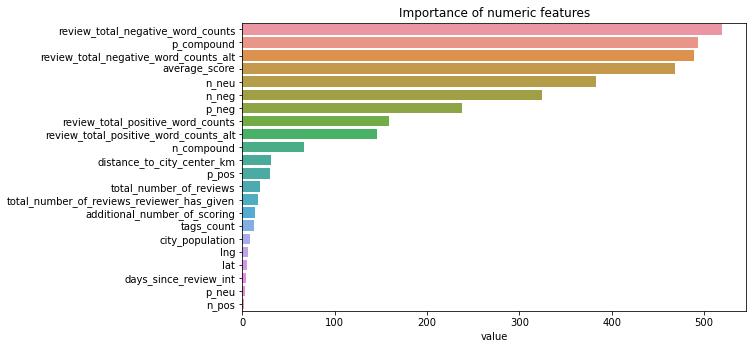

In [82]:
numeric_columns = visualize_numeric_columns_importance(train_data)

According to the diagram we will need about 10 columns. Lets test from 3 to 13 just in case.

MAPE 0.13793019848825702 for 3 numeric columns
MAPE 0.1362817581036245 for 4 numeric columns
MAPE 0.1343293159471652 for 5 numeric columns
MAPE 0.13363591176560266 for 6 numeric columns
MAPE 0.1315117851574484 for 7 numeric columns
MAPE 0.1306807903933881 for 8 numeric columns
MAPE 0.13083214595951365 for 9 numeric columns
MAPE 0.13100075863369498 for 10 numeric columns
MAPE 0.1315161218661092 for 11 numeric columns
MAPE 0.1313697788270238 for 12 numeric columns
Best MAPE 0.1306807903933881 achieved with 8 numeric columns


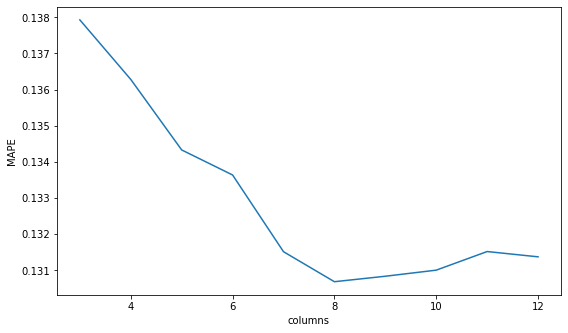

In [83]:
N_ESTIMATORS = 10
DEBUG = False

best_mape = None
best_num = None
data = []

for num in range(3, 13):
    NUMERIC_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    data.append([num, mape])
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

df = pd.DataFrame(columns=['columns', 'MAPE'], data=data)

fig, ax = figax()

sns.lineplot(x='columns', y='MAPE', data=df);

In [84]:
NUMERIC_COLUMNS_MAX_NUM = 7

#### Transforming data

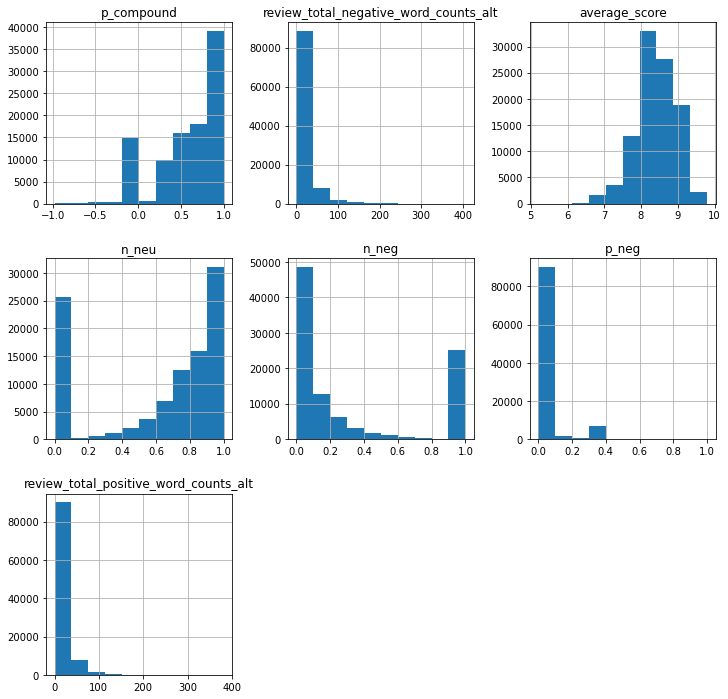

In [85]:
numeric_columns = get_selected_numeric_features(train_data)
train_data[numeric_columns].hist(figsize=(12, 12));

In [86]:
COLUMNS_TO_STANDARDIZE = ['average_score']

selected_numeric_columns = get_selected_numeric_features(train_data)

COLUMNS_TO_NORMALIZE = [x for x in selected_numeric_columns if x not in COLUMNS_TO_STANDARDIZE]

transform_features(train_data, is_train_set=True)

#### Training and estimating

In [87]:
y_pred, mape = train_and_estimate(train_data)
print(f'MAPE: {mape}')

MAPE: 0.13147512246749898


#### Selecting features again

Lets check columns with high correlation first and redefine `EXCLUDE_COLUMNS`.

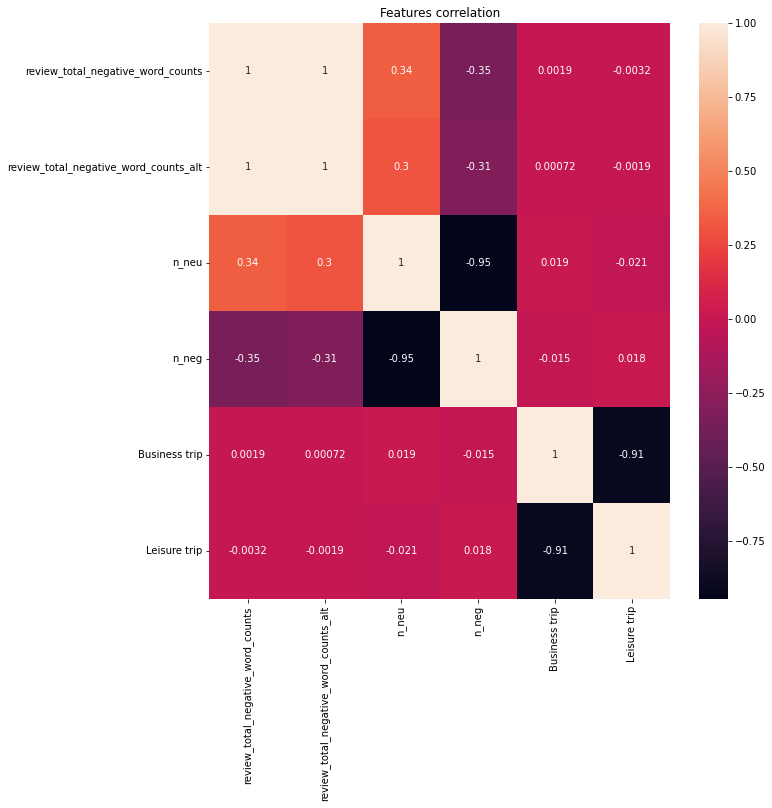

In [88]:
EXCLUDE_COLUMNS = ['lat', 'lng']
visualize_correlation(train_data, high_corr_onlly=True)

In [89]:
EXCLUDE_COLUMNS.extend([
    'review_total_negative_word_counts',
    'n_neg',
    'review_total_positive_word_counts',
    'Business trip',
])

visualize_correlation(train_data, high_corr_onlly=True)

There are no columns with high correlation.


Let's make sure that 7 numeric columns is still the best choice.

MAPE 0.13309953422868906 for 5 numeric columns
MAPE 0.12974492775402335 for 6 numeric columns
MAPE 0.12767940010407236 for 7 numeric columns
MAPE 0.12809214139862798 for 8 numeric columns
MAPE 0.12809544508965026 for 9 numeric columns
MAPE 0.12800789519934408 for 10 numeric columns
MAPE 0.12778670422442337 for 11 numeric columns
Best MAPE 0.12767940010407236 achieved with 7 numeric columns


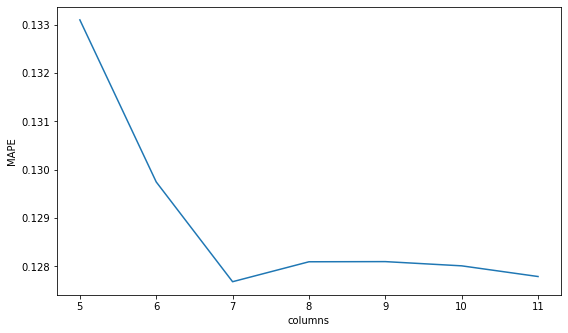

In [90]:
N_ESTIMATORS = 25
DEBUG = False

best_mape = None
best_num = None
data = []

for num in range(5, 12):
    NUMERIC_COLUMNS_MAX_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    data.append([num, mape])
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

df = pd.DataFrame(columns=['columns', 'MAPE'], data=data)

fig, ax = figax()

sns.lineplot(x='columns', y='MAPE', data=df);

In [91]:
NUMERIC_COLUMNS_MAX_NUM = 7

# Fourth submission

In [92]:
DEBUG = True
N_ESTIMATORS = 100
NUMERIC_COLUMNS_MAX_NUM = 7
CATEGORICAL_COLUMNS_MAX_NUM = 103
EXCLUDE_COLUMNS = [
    'lat',
    'lng',
    'review_total_negative_word_counts',
    'n_neg',
    'review_total_positive_word_counts',
    'Business trip']

train_data = get_train_data()
cleanup_data(train_data, is_train_set=True)
create_features(train_data, is_train_set=True)
train_data_before_transform = train_data.copy()
transform_features(train_data, is_train_set=True)

test_data = get_test_data()
cleanup_data(test_data, is_train_set=False)
create_features(test_data, is_train_set=False)
test_data_before_transform = test_data.copy()
transform_features(test_data, is_train_set=False)

train_and_make_submission(train_data, test_data, 'hotels_prediction_4.csv')

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
removed 307 duplicated rows
<<< fn. `cleanup_data__remove_duplicates` finished, took 1.1 s

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 61 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 2446
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 36.5 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 37.9 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       196625
Barcelona     45098
Paris         44494
Amsterdam     42970
Vienna        29160
Milan         27864
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 241 mls

>>> fn. `create_features__add_city_

This time the restult is **12.60532**. We were able to make a good improvement! Nonetheless let's have a look again at the worst predictions.

## Analizing worst cases again

In [93]:
DEBUG = False
N_ESTIMATORS = 25

data_with_pred = get_worst_predictions(train_data_before_transform[0:30_000])

In [94]:
features = [
    'y',
    'y_pred',
    'delta_pred',
    'average_score',
    'negative_review',
    'n_neg',
    'n_neu',
    'n_pos',
    'n_compound',
    'positive_review',
    'p_neg',
    'p_neu',
    'p_pos',
    'p_compound',
]

data_with_pred[features][0:5]

,y,y_pred,delta_pred,average_score,negative_review,n_neg,n_neu,n_pos,n_compound,positive_review,p_neg,p_neu,p_pos,p_compound
8385,2.5,9.444,-6.944,8.7,No Negative,1.0,0.0,0.0,-0.709473,All excellent,0.0,0.213013,0.787109,0.571777
7870,2.5,9.296,-6.796,7.9,No Negative,1.0,0.0,0.0,-0.709473,Great location and service Excellent staff,0.0,0.339111,0.661133,0.831543
28791,2.5,9.292,-6.792,8.6,No Negative,1.0,0.0,0.0,-0.709473,The location is excellent Modern design and a...,0.0,0.836914,0.162964,0.571777
3352,3.3,9.432,-6.132,8.7,No Negative,1.0,0.0,0.0,-0.709473,Statf need to be trained,0.0,1.000000,0.000000,0.000000
1428,2.9,8.876,-5.976,8.4,No Negative,1.0,0.0,0.0,-0.709473,very nice and friendly Service,0.0,0.313965,0.686035,0.762207


Here we see that our model made logically correct predictions as the guests did not report any negative thing. It is strange that they put low marks.

In [95]:
m1 = data_with_pred['review_total_negative_word_counts_alt'] <= 5
m2 = data_with_pred['review_total_positive_word_counts_alt'] <= 5
data_with_pred[m1 & m2][features][5:10]

,y,y_pred,delta_pred,average_score,negative_review,n_neg,n_neu,n_pos,n_compound,positive_review,p_neg,p_neu,p_pos,p_compound
22674,3.8,8.936,-5.136,8.9,Every thing,0.0,1.0,0.0,0.0,Nothing,0.000000,1.000000,0.000000,0.000000
9224,4.2,9.320,-5.120,8.1,SMALL,0.0,1.0,0.0,0.0,Clean and cool rooms,0.000000,0.285889,0.713867,0.612305
25359,3.8,8.720,-4.920,8.8,Service cleaning fixing the room,0.0,1.0,0.0,0.0,Only room size is good,0.000000,0.580078,0.419922,0.440430
25161,3.8,8.632,-4.832,8.5,everything,0.0,1.0,0.0,0.0,anything,0.000000,1.000000,0.000000,0.000000
25000,3.8,8.544,-4.744,8.9,Everything,0.0,1.0,0.0,0.0,No Positive,0.378906,0.000000,0.621094,0.340088


Wrongly predicted rows contain words that our language utility can't properly estimate, like "notihng", "everything", "anything", "no positive" etc.

Lets have a look at the other end of the table.

In [96]:
m3 = data_with_pred['y'] < 10
data_with_pred[m1 & m2 & m3][features][-10:]

,y,y_pred,delta_pred,average_score,negative_review,n_neg,n_neu,n_pos,n_compound,positive_review,p_neg,p_neu,p_pos,p_compound
11018,9.2,6.924,2.276,7.9,No room free wifi,0.292969,0.267090,0.439941,0.273193,The location,0.000000,1.0,0.000000,0.000000
29873,9.6,7.280,2.320,8.1,Breakfast very expensive,0.000000,1.000000,0.000000,0.000000,Staff cleaning,0.000000,1.0,0.000000,0.000000
29612,9.2,6.548,2.652,7.8,No bottled water in room,0.354980,0.645020,0.000000,-0.295898,No Positive,0.378906,0.0,0.621094,0.340088
11144,8.8,6.068,2.732,8.3,extra for infant bed,0.000000,1.000000,0.000000,0.000000,location,0.000000,1.0,0.000000,0.000000
12283,9.6,6.728,2.872,7.5,Room size,0.000000,1.000000,0.000000,0.000000,Location location location,0.000000,1.0,0.000000,0.000000
24364,9.2,6.072,3.128,7.1,Needs a complete overhaul,0.000000,1.000000,0.000000,0.000000,No Positive,0.378906,0.0,0.621094,0.340088
15397,9.2,6.064,3.136,7.0,Bathroom was a little small,0.000000,1.000000,0.000000,0.000000,No Positive,0.378906,0.0,0.621094,0.340088
20460,9.2,5.692,3.508,6.7,Only bathroom outdated looks tired,0.419922,0.580078,0.000000,-0.440430,No Positive,0.378906,0.0,0.621094,0.340088
4964,9.6,5.616,3.984,8.5,Very small,0.000000,1.000000,0.000000,0.000000,No Positive,0.378906,0.0,0.621094,0.340088
23963,9.6,5.492,4.108,7.9,Wi Fi too poor,0.507812,0.491943,0.000000,-0.476807,Location,0.000000,1.0,0.000000,0.000000


According to the comments, especially the negative ones, the guests were not very happy. Hard to say why they put high marks. The predicted marks look right 👍

# Outcome

We made a full cycle of a data scientist single work:
- we've got the task and the data
- we prepared the data to train a model which included
  - data cleaning
  - feature engineering
  - feature selection
  - data transformation
- we trained the model and analyzed the results
- we repeated the process several times to improve the results

We get to know Kaggle platform and participated to a competiotion. Unfortunately we didn't win, but we had a great experience, which will be very helpful in the future.